This document is divided into following steps:
1. Data loading and understading.
2. Data cleaning and preparation.
3. Feature engineering.
4. Modelling (churn prediction).
5. Identifying important churn indicators and.
6. Business Recommendations.

In [1]:
# Ignoring warning messages
import warnings
warnings.filterwarnings('ignore')

# Import the required library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
pd.set_option('display.max_columns',230)
# pd.set_option('display.max_rows',230)

In [2]:
# Read the csv file into the data frame.
telecom_df = pd.read_csv("telecom_churn_data.csv")

In [3]:
# Checking the top 5 rows of the data frame
telecom_df.head().T

,0,1,2,3,4
mobile_number,7000842753,7001865778,7001625959,7001204172,7000142493
circle_id,109,109,109,109,109
loc_og_t2o_mou,0,0,0,0,0
std_og_t2o_mou,0,0,0,0,0
loc_ic_t2o_mou,0,0,0,0,0
...,...,...,...,...,...
aon,968,1006,1103,2491,1526
aug_vbc_3g,30.4,0,0,0,0
jul_vbc_3g,0,0,0,0,0
jun_vbc_3g,101.2,0,4.17,0,0


In [4]:
# Reading the Shape of the dataFrame. 
telecom_df.shape

(99999, 226)

In [5]:
# Looking at null values
telecom_df.isnull().sum().sort_values(ascending=False)

count_rech_2g_6             74846
date_of_last_rech_data_6    74846
count_rech_3g_6             74846
av_rech_amt_data_6          74846
max_rech_data_6             74846
                            ...  
last_day_rch_amt_6              0
last_day_rch_amt_7              0
last_day_rch_amt_8              0
last_day_rch_amt_9              0
mobile_number                   0
Length: 226, dtype: int64

In [6]:
# Looking at missing value percentage
round((telecom_df.isnull().sum()/len(telecom_df.index) * 100).sort_values(ascending=False), 2)

count_rech_2g_6             74.85
date_of_last_rech_data_6    74.85
count_rech_3g_6             74.85
av_rech_amt_data_6          74.85
max_rech_data_6             74.85
                            ...  
last_day_rch_amt_6           0.00
last_day_rch_amt_7           0.00
last_day_rch_amt_8           0.00
last_day_rch_amt_9           0.00
mobile_number                0.00
Length: 226, dtype: float64

In [7]:
# Defining a funtion to add the count/frequency values as annotation to histogram.
def annotate_graph(ax):
    for bar in ax.patches:         
        ax.annotate(format((bar.get_height()), '.1f'),                    
                    (bar.get_x() + bar.get_width() / 2,  bar.get_height()),                    
                    ha='center', va='center',                    
                    size=10, xytext=(0, 8),                    
                    textcoords='offset points')
    return ax

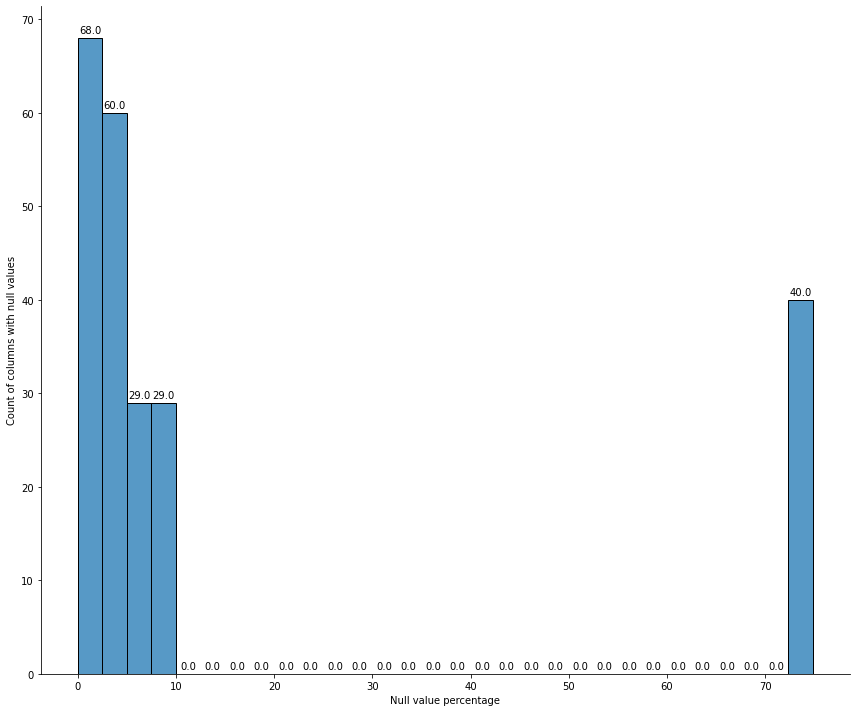

In [8]:
# Plotting histogram for the dataframe and columns having null values.
plt.figure(figsize=(12,10))

ax = sns.histplot(round((telecom_df.isnull().sum()/len(telecom_df.index) * 100).sort_values(ascending=False), 2))
ax = annotate_graph(ax)
ax.set(xlabel='Null value percentage', ylabel='Count of columns with null values')
sns.despine()
plt.tight_layout()

## Observation

- There are 40 columns which have more than 70% missing values. 
- They are a cause of major information loss and should be dropped unless they are vital for our analysis. 

In [9]:
# defining a function to get more than cutoff percent missing value

def get_missing_value_percentage(cutoff):
    y = pd.DataFrame( round((telecom_df.isnull().sum()/len(telecom_df.index) * 100).sort_values(ascending=False), 2))
    y.rename(columns={0:"Percentage"}, inplace=True)
    y2 = y[y.Percentage>cutoff]
    return y2

In [10]:
# get columns with more than 70% missing values
greater_than_70 = get_missing_value_percentage(70)

In [11]:
len(greater_than_70)

40

In [12]:
greater_than_70

,Percentage
count_rech_2g_6,74.85
date_of_last_rech_data_6,74.85
count_rech_3g_6,74.85
av_rech_amt_data_6,74.85
max_rech_data_6,74.85
total_rech_data_6,74.85
arpu_3g_6,74.85
arpu_2g_6,74.85
night_pck_user_6,74.85
fb_user_6,74.85


## Observation:
We can see Key Performance Indicators from the month of June, July (Good Phase), August (Action Phase) and September (Churn Phase), are also in the list of columns with more than 70% missing values. Presence of missing values in these KPIs indicate that the customer did not use these features in the respective months. Therefore, it is safe to impute "0" in their missing values.

`High-value customers - Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in June and July (the good phase).`

So we have to take care of these columns so that we do not drop the columns related to the recharge amounts. First we have to deal with the missing values in these columns -  

- **total_rech_data_6**  - 74.85 % missing values
- **total_rech_data_7**  - 74.43 % missing values
- **av_rech_amt_data_6** - 74.85 % missing values
- **av_rech_amt_data_7** - 74.43 % missing values
- **date_of_last_rech_data_6** - 74.85 % missing values
- **date_of_last_rech_data_7** - 74.43 % missing values

As the above columns have the information of recharge data and recharge amount if customer has not recharged we can consider that there were missing values so, we can impute missing values with 0.

In [13]:
import missingno as msno

<AxesSubplot:>

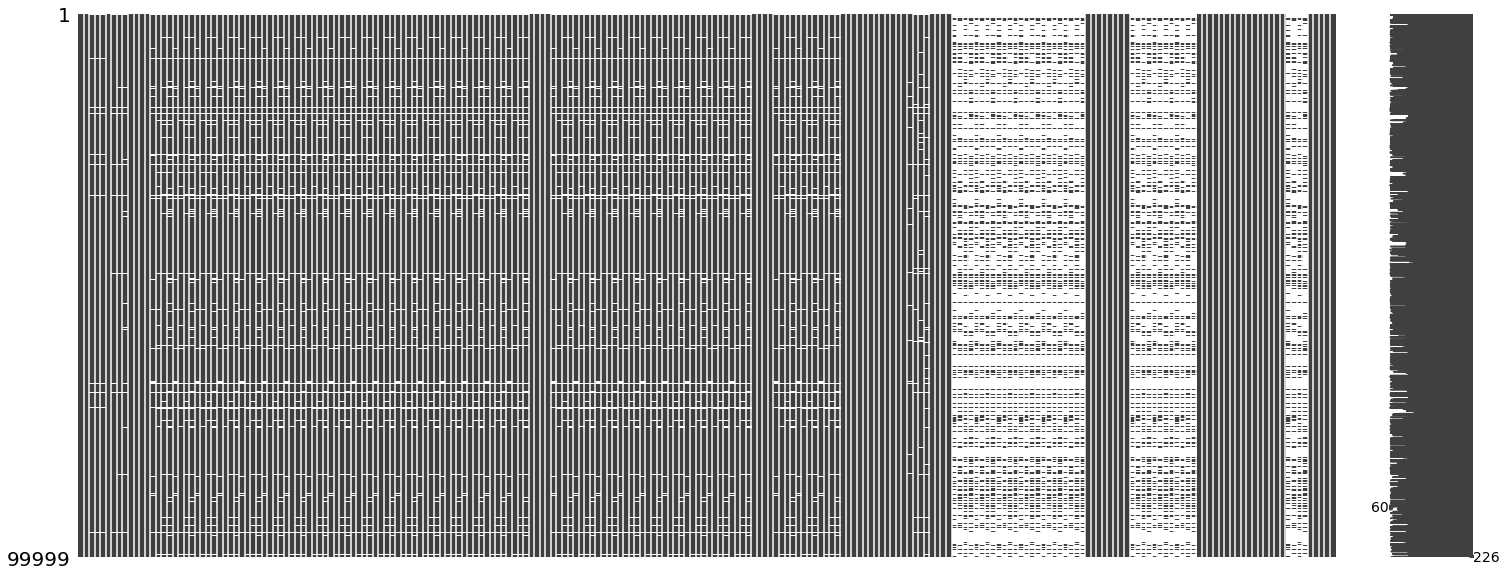

In [14]:
msno.matrix(telecom_df)

In [15]:
# Imputing the missing values with 0 as explained above.
# Month 6
telecom_df['total_rech_data_6'].fillna(0, inplace=True)
telecom_df['av_rech_amt_data_6'].fillna(0, inplace=True)

# Month 7
telecom_df['total_rech_data_7'].fillna(0, inplace=True)
telecom_df['av_rech_amt_data_7'].fillna(0, inplace=True)

# Month 8
telecom_df['total_rech_data_8'].fillna(0, inplace=True)
telecom_df['av_rech_amt_data_8'].fillna(0, inplace=True)

In [16]:
# Now checking the number of columns with more than 70% missing values

greater_than_70 = get_missing_value_percentage(70)
len(greater_than_70)

34

In [17]:
# Checking the number of columns with more than 70% missing values
greater_than_70

,Percentage
night_pck_user_6,74.85
fb_user_6,74.85
count_rech_3g_6,74.85
max_rech_data_6,74.85
date_of_last_rech_data_6,74.85
arpu_3g_6,74.85
arpu_2g_6,74.85
count_rech_2g_6,74.85
fb_user_7,74.43
date_of_last_rech_data_7,74.43


### Observation

- There is still 34 columns with more than 70% missing values. 
- But this is more than 70% of the total dataset. 
- We are only interested in High Value Customers
- We will filter High Value Customers first then check how many columns still have high missing values


# Data Preparation

## Derive new features

### Observation

- Total Amount = Total Frequency * Average Amount

In [18]:
# New Feature Creation based on this Total Amount = Total Frequency * Average Amount for all 4 months
telecom_df['total_data_rech_amt_6'] = telecom_df['total_rech_data_6'] * telecom_df['av_rech_amt_data_6']
telecom_df['total_data_rech_amt_7'] = telecom_df['total_rech_data_7'] * telecom_df['av_rech_amt_data_7']
telecom_df['total_data_rech_amt_8'] = telecom_df['total_rech_data_8'] * telecom_df['av_rech_amt_data_8']
telecom_df['total_data_rech_amt_9'] = telecom_df['total_rech_data_9'] * telecom_df['av_rech_amt_data_9']

### Filtering High Value Customers

Find the Recharge amount of June and July

- Recharge Amount = Talk Time recharge + Data Recharge Amount

In [19]:
# Those who have recharged with an amount more than or equal to X, 
# where X is the 70th percentile of the average recharge amount in 
# the first two months (the good phase).
average_goodPhase_rechage = telecom_df[['total_data_rech_amt_6','total_data_rech_amt_7','total_rech_amt_6','total_rech_amt_7']].mean(axis = 1)

In [20]:
# Finding the 70 th percentile of the average recharge amount in the first two months (the good phase)
average_goodPhase_rechage_70Percentile = np.percentile(average_goodPhase_rechage, 70)
average_goodPhase_rechage_70Percentile

239.0

In [21]:
# Filtering the high values cutomers where average_goodPhase_rechage >= average_goodPhase_rechage_70Percentile.

telecom_df = telecom_df[average_goodPhase_rechage >= average_goodPhase_rechage_70Percentile]

In [22]:
# Checking the new shape
telecom_df.shape

(30001, 230)

In [23]:
# Checking top 5 rows of the data frame.
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,

So after filtering out the high-value customers we are left with 30001 observations and 230 columns

In [24]:
# Index numbers need to be reset as many rows have been deleted

telecom_df = telecom_df.reset_index(drop=True)
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,

In [25]:
# Dusplaying the last 10 columns of the data frame.
telecom_df.columns[-10:]

Index(['fb_user_9', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'sep_vbc_3g', 'total_data_rech_amt_6', 'total_data_rech_amt_7',
       'total_data_rech_amt_8', 'total_data_rech_amt_9'],
      dtype='object')

# Observations
- As seen above the last month columns are not aligned with the rest of the naming convention.
- We will rename these columns to align with the rest of the columns in data frame.
 

In [26]:
# Last few columns have month name in them. They need to be renamed to our general format.
telecom_df.rename(columns = {'jun_vbc_3g':'vbc_3g_6',
                               'jul_vbc_3g':'vbc_3g_7',
                               'aug_vbc_3g':'vbc_3g_8',
                               'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

## Tag churners and remove attributes of the churn phase

## Creating Churn Column

- A customer is said to have churned if he, for the month of September, has met the following conditions simultaneously

- **No Incoming calls**: total_ic_mou_9
- **No Outgoing Calls**: total_og_mou_9
- **No 2G Data**: vol_2g_mb_9
- **No 3G Data**: vol_3g_mb_9

In [27]:
# Creating churn = 1 if customers not made any calls (either incoming or outgoing) 
# AND have not used mobile internet even once in the churn phase.
telecom_df['churn'] = telecom_df.apply(lambda x: 1 if((x.total_ic_mou_9 == 0) and 
                                                          (x.total_og_mou_9 == 0) and 
                                                          (x.vol_2g_mb_9 == 0) and 
                                                          (x.vol_3g_mb_9 == 0)) else 0, axis=1)

In [28]:
# Checking the values of the churn column of data frame.
telecom_df['churn'].value_counts()

0    27560
1     2441
Name: churn, dtype: int64

In [29]:
# Getting the names of the all the columns ending with _9 which is related to churn phase.
cols = list(telecom_df.columns)
sep_cols=[]
for col in cols:
    if col[-2:]=="_9":
        sep_cols.append(col)

        
sep_cols

['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'date_of_last_rech_data_9',
 'total_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 

In [30]:
# Checking the size of sep_cols
len(sep_cols)

56

In [31]:
# Dropping these 56 columns as we have derived churn column form the september/9 month data.
# Keeping these dusing training phase will result in information leak so it must be dropped.

telecom_df.drop(sep_cols,inplace=True,axis=1)

In [32]:
# Checking Shape
telecom_df.shape

(30001, 175)

# Data Cleaning

In [33]:
# Checking columns with missing values greater than 70 %
greater_than_70 = get_missing_value_percentage(70)
len(greater_than_70)

0

In [34]:
# Checking columns with missing values greater than 40 %
greater_than_40 = get_missing_value_percentage(40)
len(greater_than_40)

24

### Observation
- No columns with more than 70% missing values
- 24 columns with more than 40% missing values

In [35]:
# Checking columns with missing values greater than 40 %
greater_than_40

,Percentage
count_rech_3g_8,46.83
count_rech_2g_8,46.83
max_rech_data_8,46.83
arpu_3g_8,46.83
fb_user_8,46.83
arpu_2g_8,46.83
night_pck_user_8,46.83
date_of_last_rech_data_8,46.83
count_rech_2g_6,44.15
count_rech_3g_6,44.15


**'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'** 
- Dropping them as we cannot impute values for these date related columns.

In [36]:
telecom_df.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 
                 'date_of_last_rech_data_8'], axis=1, inplace = True)

**'max_rech_data_6', 'max_rech_data_7' & 'max_rech_data_8'**

In [37]:
# Displaying the total number of null values for max_rech_data_6,max_rech_data_7,max_rech_data_8
print("Total NULL values for max_rech_data_6 columns is - ", telecom_df.max_rech_data_6.isnull().sum())
print("Total NULL values for max_rech_data_7 columns is - ", telecom_df.max_rech_data_7.isnull().sum())
print("Total NULL values for max_rech_data_8 columns is - ", telecom_df.max_rech_data_8.isnull().sum())

Total NULL values for max_rech_data_6 columns is -  13245
Total NULL values for max_rech_data_7 columns is -  12944
Total NULL values for max_rech_data_8 columns is -  14048


In [38]:
print("MONTH-6")
print(telecom_df.max_rech_data_6.describe())


print('-------------------------------------')

print("\n\n")
print("MONTH-7")
print(telecom_df.max_rech_data_7.describe())


print('-------------------------------------')

print("\n\n")
print("MONTH-8")
print(telecom_df.max_rech_data_8.describe())

MONTH-6
count    16756.000000
mean       139.798580
std        118.851784
min          1.000000
25%         25.000000
50%        152.000000
75%        198.000000
max       1555.000000
Name: max_rech_data_6, dtype: float64
-------------------------------------



MONTH-7
count    17057.000000
mean       140.431143
std        120.247247
min          1.000000
25%         25.000000
50%        152.000000
75%        198.000000
max       1555.000000
Name: max_rech_data_7, dtype: float64
-------------------------------------



MONTH-8
count    15953.000000
mean       136.329217
std        119.531924
min          1.000000
25%         25.000000
50%        152.000000
75%        198.000000
max       1555.000000
Name: max_rech_data_8, dtype: float64


### Obsevation
- Minimum for all three = 1
- Maximum for all three = 1555
- Average for all three = 140 (approx)

Since minimum is 1, when no recharge was done, the column must have been left empty. Therefore, filling them with 0

In [39]:
# Replace NA with 0
for col in ['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']:
    telecom_df[col].fillna(0, inplace=True)

In [40]:
# Checking columns with missing values greater than 40 %
greater_than_40 = get_missing_value_percentage(40)
greater_than_40

,Percentage
arpu_3g_8,46.83
count_rech_2g_8,46.83
count_rech_3g_8,46.83
arpu_2g_8,46.83
fb_user_8,46.83
night_pck_user_8,46.83
count_rech_3g_6,44.15
count_rech_2g_6,44.15
night_pck_user_6,44.15
fb_user_6,44.15


In [41]:
# Getting the number of missing values from the cols with more than 40% missing values
col_name = greater_than_40.index
col_val = []
for col in col_name:
    col_val.append(telecom_df[col].isnull().sum())
    
Top40_missing_value_percentage = pd.DataFrame(zip(col_name, col_val))

In [42]:
# Getting the number of missing values column wise.
Top40_missing_value_percentage = Top40_missing_value_percentage.rename(columns={0:"Column",1:"Missing_Vals"})
Top40_missing_value_percentage

,Column,Missing_Vals
0,arpu_3g_8,14048
1,count_rech_2g_8,14048
2,count_rech_3g_8,14048
3,arpu_2g_8,14048
4,fb_user_8,14048
5,night_pck_user_8,14048
6,count_rech_3g_6,13245
7,count_rech_2g_6,13245
8,night_pck_user_6,13245
9,fb_user_6,13245


- Now all the columns that have more than 40% missing values somehow relate to internet usage for the months 6, 7 & 8 respectively. 


- One important observation that comes out is that for a particular month all these values have same number of missing values.

**Count of missing values for Month 6**
- **count_rech_2g_6**.   -------->          13245
- **count_rech_3g_6**.   -------->          13245
- **arpu_3g_6**.          ---------------->                13245
- **arpu_2g_6**.          ---------------->                13245
- **night_pck_user_6**.   -------->         13245

\
\
**Count of missing values for Month 7**
- **count_rech_2g_7**.   -------->          12944
- **count_rech_3g_7**.   -------->          12944
- **arpu_3g_7**.          ---------------->                12944
- **arpu_2g_7**.          ---------------->                12944
- **night_pck_user_7**.   -------->         12944


\
\
**Count of missing values for Month 8**
- **count_rech_2g_8**.     -------->          14048
- **count_rech_3g_8**.     -------->          14048
- **arpu_3g_8**.           ---------------->          14048
- **arpu_2g_8**.           ---------------->          14048
- **night_pck_user_8**.    -------->          14048
    
So now lets check & confirm if these missing values from the respective months are all from the same observations/index.


### Observation

- There is an increase in internet usage in the 8th month.

- If all the above objects are equal for all entries, then we can confirm that the missing values are all from the same observation.

In [43]:
# Month 6

arpu_3g_6_index = telecom_df['arpu_3g_6'].isnull()
night_pck_user_6_index = telecom_df['night_pck_user_6'].isnull()
count_rech_2g_6_index = telecom_df['count_rech_2g_6'].isnull()
count_rech_3g_6_index = telecom_df['count_rech_3g_6'].isnull()
fb_user_6_index = telecom_df['fb_user_6'].isnull()


if arpu_3g_6_index.equals(night_pck_user_6_index) & night_pck_user_6_index.equals(count_rech_2g_6_index) & count_rech_2g_6_index.equals(count_rech_3g_6_index) &  count_rech_3g_6_index.equals(fb_user_6_index):
    print('The indexes for NULL values for month 6 are equal')


# ***************************************************************************************************************************

# Month 7

arpu_3g_7_index = telecom_df['arpu_3g_7'].isnull()
night_pck_user_7_index = telecom_df['night_pck_user_7'].isnull()
count_rech_2g_7_index = telecom_df['count_rech_2g_7'].isnull()
count_rech_3g_7_index = telecom_df['count_rech_3g_7'].isnull()
fb_user_7_index = telecom_df['fb_user_7'].isnull()


if arpu_3g_7_index.equals(night_pck_user_7_index) & night_pck_user_7_index.equals(count_rech_2g_7_index) & count_rech_2g_7_index.equals(count_rech_3g_7_index) &  count_rech_3g_7_index.equals(fb_user_7_index):
    print('The indexes for NULL values for month 7 are equal')

# ***************************************************************************************************************************

# Month 8

arpu_3g_8_index = telecom_df['arpu_3g_8'].isnull()
night_pck_user_8_index = telecom_df['night_pck_user_8'].isnull()
count_rech_2g_8_index = telecom_df['count_rech_2g_8'].isnull()
count_rech_3g_8_index = telecom_df['count_rech_3g_8'].isnull()
fb_user_8_index = telecom_df['fb_user_8'].isnull()


if arpu_3g_8_index.equals(night_pck_user_8_index) & night_pck_user_8_index.equals(count_rech_2g_8_index) & count_rech_2g_8_index.equals(count_rech_3g_8_index) &  count_rech_3g_8_index.equals(fb_user_8_index):
    print('The indexes for NULL values for month 8 are equal')


The indexes for NULL values for month 6 are equal
The indexes for NULL values for month 7 are equal
The indexes for NULL values for month 8 are equal


### Observsation

- If a user is not using Internet, then he won't be using other Internet related services: FaceBook, 3G, 2G recharge etc

In [44]:
# Filling internet related services with 0.

columns_to_impute = ['count_rech_2g_6', 'count_rech_2g_7',
       'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7',
       'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

telecom_df[columns_to_impute] = telecom_df[columns_to_impute].fillna(0)

In [45]:
# Getting the top 5 rows of the data frame.
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,252.0,252.0,252.0,1
1,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.0,0.0,0.0,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580

In [46]:
# Checking columns with more than 40% missing values
greater_than_40 = get_missing_value_percentage(40)
len(greater_than_40)

0

### Observation

- There must be columns with only one type of value
- That is, their value_counts() has only one unique value. For eg: oc_og_t2o_mou

In [47]:
# Checking the values of loc_og_t2o_mou column.
telecom_df.loc_og_t2o_mou.value_counts()

0.0    29777
Name: loc_og_t2o_mou, dtype: int64

## Observations
- As all the values are 0 so we need to delete these columns as they offer no information.

In [48]:
# Getting the columns which are having variance equal to 0.
telecom_df.var() == 0

mobile_number            False
circle_id                 True
loc_og_t2o_mou            True
std_og_t2o_mou            True
loc_ic_t2o_mou            True
                         ...  
vbc_3g_6                 False
total_data_rech_amt_6    False
total_data_rech_amt_7    False
total_data_rech_amt_8    False
churn                    False
Length: 166, dtype: bool

In [49]:
# The total number of columns having variance equal to 0.
(telecom_df.var() == 0).sum()

10

In [50]:
# Getting the columns having variance of 0 into a data frame.
cols_with_one_unique_value = pd.DataFrame(telecom_df.var() == 0)

cols_with_one_unique_value.reset_index(inplace=True)

cols_with_one_unique_value = cols_with_one_unique_value.rename(columns={"index":"Col", 0:"Zero_variance"})

In [51]:
# Checking top 5 rows of cols_with_one_unique_value.
cols_with_one_unique_value.head()

,Col,Zero_variance
0,mobile_number,False
1,circle_id,True
2,loc_og_t2o_mou,True
3,std_og_t2o_mou,True
4,loc_ic_t2o_mou,True


In [52]:
# Getting the name of the columns with one unique value.
cols_with_one_unique_value = cols_with_one_unique_value.loc[cols_with_one_unique_value['Zero_variance']==True]

one_unique_value = []
for x in cols_with_one_unique_value["Col"]:
    one_unique_value.append(x)
    
    
one_unique_value

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [53]:
# Dropping these columns with only one value type.

telecom_df.drop(one_unique_value, inplace=True, axis=1)

In [54]:
# Checking the shape of the dat frame.
telecom_df.shape

(30001, 162)

In [55]:
# Looking at columns with number of unique values = 1
pd.DataFrame(telecom_df.nunique() == 1)

,0
mobile_number,False
last_date_of_month_6,True
last_date_of_month_7,True
last_date_of_month_8,True
arpu_6,False
...,...
vbc_3g_6,False
total_data_rech_amt_6,False
total_data_rech_amt_7,False
total_data_rech_amt_8,False


In [56]:
# Checking the value counts of last_date_of_month_6 column.
telecom_df['last_date_of_month_6'].value_counts()

6/30/2014    30001
Name: last_date_of_month_6, dtype: int64

### Observation

- If a user is active then his last usage date in the month of June will be the last date of June. 

Therefore, we cannot simply impute or delete in case of date columns

In [57]:
# There are still 1838 rows and 86 columns with missing values

print("Rows with missing values: ",telecom_df.isnull().any(axis=1).sum())
print("Columns with missing values: ",telecom_df.isnull().any(axis=0).sum())

Rows with missing values:  1838
Columns with missing values:  86


In [58]:
# Getting the list of columns with missing values.
cols_with_missing_values = list(telecom_df.columns[telecom_df.isna().any()])
cols_with_missing_values

['last_date_of_month_7',
 'last_date_of_month_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic

In [59]:
# Checking missing values columns by MONTH

missing_val_6 = []
missing_val_7 = []
missing_val_8 = []

for col in cols_with_missing_values:
    last = col[-1:]
    if last=="6":
        missing_val_6.append(col)
    elif last=="7":
        missing_val_7.append(col)
    elif last=="8":
        missing_val_8.append(col)
    else:
        continue

In [60]:
# Displaying the missing values month wise.
print("Number of columns missing in June:    ",len(missing_val_6))
print("\nNumber of columns missing in July:    ",len(missing_val_7))
print("\nNumber of columns missing in August:    ",len(missing_val_8))

Number of columns missing in June:     28

Number of columns missing in July:     29

Number of columns missing in August:     29


In [61]:
# Like discussed above, we cannot remove columns with date attributes
cols_with_missing_values = [x for x in cols_with_missing_values if not 'date' in x]
cols_with_missing_values

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou

In [62]:
# Dropping the columns with missing values.
telecom_df.drop(cols_with_missing_values, axis=1, inplace=True)

In [63]:
# Checking the shape of the data frame.
telecom_df.shape

(30001, 81)

In [64]:
print("Columns with missing values: ",telecom_df.isnull().any(axis=0).sum())

Columns with missing values:  5


### Date Columns

In [65]:
# Getting the list of all the date columns.
date_columns = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 
                'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8']

telecom_df[date_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_of_last_rech_6   29928 non-null  object
 1   date_of_last_rech_7   29903 non-null  object
 2   date_of_last_rech_8   29418 non-null  object
 3   last_date_of_month_6  30001 non-null  object
 4   last_date_of_month_7  29974 non-null  object
 5   last_date_of_month_8  29836 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


In [66]:
# Problem statement given to us does not need date columns.

telecom_df.drop(date_columns, axis=1, inplace = True)

In [67]:
telecom_df.shape

(30001, 75)

In [68]:
# Checking null values
print(telecom_df.isnull().any(axis=1).sum())
print(telecom_df.isnull().any(axis=0).sum())

0
0


### Observation

There are no null values present now

**ARPU - Average Revenue Per User** 

Now as per the defination of ARPU which says - "**The average revenue per user is the average billing per customer earned by the telecom company every month**".

In [69]:
# Let's check the data description for the arpu columns

arpu_columns = ['arpu_6', 'arpu_7', 'arpu_8']


def describe_ARPU_Columns():
    for column in arpu_columns:
        print('\n',column,'\n')
        print(telecom_df[column].describe(), end='\n')
        print("----------------------------------------", end='\n')

        
describe_ARPU_Columns()


 arpu_6 

count    30001.000000
mean       558.490824
std        460.640461
min      -2258.709000
25%        309.865000
50%        481.694000
75%        699.943000
max      27731.088000
Name: arpu_6, dtype: float64
----------------------------------------

 arpu_7 

count    30001.000000
mean       560.782203
std        479.776947
min      -2014.045000
25%        309.826000
50%        480.943000
75%        698.315000
max      35145.834000
Name: arpu_7, dtype: float64
----------------------------------------

 arpu_8 

count    30001.000000
mean       508.597957
std        501.961981
min       -945.808000
25%        231.473000
50%        427.585000
75%        661.491000
max      33543.624000
Name: arpu_8, dtype: float64
----------------------------------------


### Observation

- revenue generated from a user cannot be negative. 
- Minimum Revenue should not be less than zero

In [70]:
# Index where the arpu values for month 6 are less than 0 -

arpu_6_index = (telecom_df['arpu_6'] < 0)
    
# Total number of such observations for month 6 -
print('Total observations with negative arpu values for June:', arpu_6_index.sum())

Total observations with negative arpu values for June: 39


In [71]:
# Index where the arpu values for month 7 are less than 0 -

arpu_7_index = (telecom_df['arpu_7'] < 0)
    
# Total number of such observations for month 6 -
print('Total observations with negative arpu values for July:', arpu_7_index.sum())

Total observations with negative arpu values for July: 50


In [72]:
# Index where the arpu values for month 8 are less than 0 -

arpu_8_index = (telecom_df['arpu_8'] < 0)
    
# Total number of such observations for month 7 -
print('Total observations with negative arpu values for August -', arpu_8_index.sum())

Total observations with negative arpu values for August - 90


In [73]:
# Let's delete the observations with negative arpu values. 

telecom_df = telecom_df[(telecom_df['arpu_6'] >= 0) & 
                            (telecom_df['arpu_7'] >= 0) & 
                            (telecom_df['arpu_8'] >= 0)]

In [74]:
# Checking the shape of the data frame.
telecom_df.shape

(29824, 75)

In [75]:
# Checking the null values
telecom_df.isnull().any().sum()

0

### Duplicate Row Checker

In [76]:
if len(telecom_df['mobile_number'].unique()) == len(telecom_df.index):
    print("No Duplicates. Each Mobile Number is unique.")
else:
    print("Duplicate observations present.")

No Duplicates. Each Mobile Number is unique.


In [77]:
# Also we do not need the column 'mobile_number' during our analysis so dropping.

telecom_df.drop(['mobile_number'], axis=1, inplace = True)

# Exploratory Data Analysis

In [78]:
# Summary Statistics
telecom_df.describe()

,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,churn
count,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.00000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000,29824.000000
mean,559.219456,562.562717,510.085640,609.875318,629.333328,552.608763,290.629534,297.906546,281.173369,11.857631,11.749464,10.014250,660.539767,661.379493,586.365343,168.492724,171.420433,160.375402,100.112326,99.953628,92.323766,1.667382,1.85847,1.628856,78.109643,79.998894,72.777763,1.240109,1.400818,1.213653,0.427273,0.457652,0.415203,130.694492,140.072982,122.621106,126.702837,125.500523,106.360809,344.676775,371.089760,352.732650,67.006198,68.743933,63.028106,63.402471,64.802207,58.592644,0.013546,0.012574,0.011400,0.174859,0.183912,0.154272,1.065249,1.216906,1.059382,0.217778,0.229513,0.211876,0.209496,0.228138,0.203326,0.517939,0.525181,0.478977,1211.066658,169.511731,179.168692,158.833359,455.662311,529.663834,465.245861,0.079265
std,459.504626,478.650800,501.034006,688.484630,715.289136,697.034405,365.901065,374.394457,361.723967,9.388855,9.428870,9.274314,559.338603,581.408102,609.264281,170.598147,176.617635,170.882979,137.713978,136.766569,142.332785,2.829271,3.09563,3.001351,112.604619,114.270876,110.692219,2.498872,2.729464,2.541825,1.169133,1.285835,1.279601,200.412572,206.935121,195.845838,330.634468,332.191727,314.098374,915.090953,917.092198,920.707464,179.322608,183.396597,170.508732,161.067280,165.490652,152.704039,0.115599,0.111427,0.106163,0.435303,0.451008,0.407125,2.503882,2.739588,2.540698,0.613546,0.660180,0.618597,0.986973,1.092566,1.103154,0.499686,0.499374,0.499566,958.051635,421.157468,443.476450,417.234935,1420.726007,1479.185031,1626.866172,0.270156
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.280000,-26.040000,-24.490000,-15.320000,-15.480000,-24.430000,0.000000,0.000000,0.000000,0.000000,0.0000

In [79]:
# Getting the list of numerical columns.
numerical_cols = list(telecom_df.describe().columns)

In [80]:
# Checking the values of night_pck_user_6 column.
telecom_df.night_pck_user_6.value_counts()

0.0    29420
1.0      404
Name: night_pck_user_6, dtype: int64

In [81]:
# Checking the number of values for night_pck_user_6 column.
len(telecom_df.night_pck_user_6.value_counts())

2

In [82]:
telecom_df.night_pck_user_6.value_counts().index[1]

1.0

In [83]:
# Finding categorical columns with 
def categorical_col(df):
    res = []
    cols = df.columns
    
    for col in cols: 
        length = len(telecom_df[col].value_counts())
        first = telecom_df[col].value_counts().index[0]
                
        if length<2:
            continue
            
        second = telecom_df[col].value_counts().index[1]

            
        if (length==2 ):
            res.append(col)
    
    return res

In [84]:
# Getting the list of categorical columns.
category_list = categorical_col(telecom_df)

In [85]:
# Getting the list of categorical columns.
category_list

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'churn']

In [86]:
category_list = category_list[:-1] # Excluding churn column and getting all other category columns.

telecom_df[category_list] = telecom_df[category_list].astype("category")

telecom_df[category_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29824 entries, 0 to 30000
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  29824 non-null  category
 1   night_pck_user_7  29824 non-null  category
 2   night_pck_user_8  29824 non-null  category
 3   fb_user_6         29824 non-null  category
 4   fb_user_7         29824 non-null  category
 5   fb_user_8         29824 non-null  category
dtypes: category(6)
memory usage: 408.3 KB


### Univariate Analysis - Ordered Categorical Variables

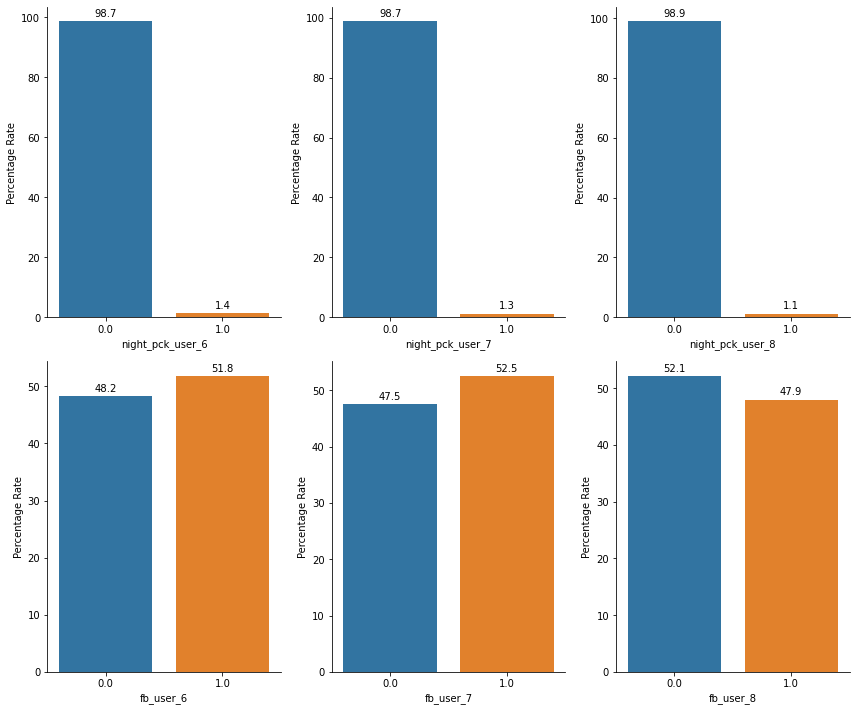

In [87]:
# Univariate Plot Analysis of Ordered categorical variables vs Percentage Rate
counter = 1

plt.figure(figsize = (12, 10))

for col_list in category_list:
        
    series = round(((telecom_df[col_list].value_counts())/(len(telecom_df[col_list])) * 100), 2)

    plt.subplot(2, 3, counter)
    ax = sns.barplot(x = series.index, y = series.values, order = series.sort_index().index)
    plt.xlabel(col_list)
    plt.ylabel('Percentage Rate')


    annotate_graph(ax)

    counter += 1


sns.despine()
plt.tight_layout()
plt.show()



### Observations

- The service schemes for Facebook seems to be popular among the potential churn customers. 

- The company can offer better Facebook schemes to retain such customers.

In [88]:
# Get number of positve and negative examples
pos = telecom_df[telecom_df["churn"] == 1].shape[0]
neg = telecom_df[telecom_df["churn"] == 0].shape[0]

print("Positive examples = ",pos)
print("Negative examples = ",neg)

Positive examples =  2364
Negative examples =  27460


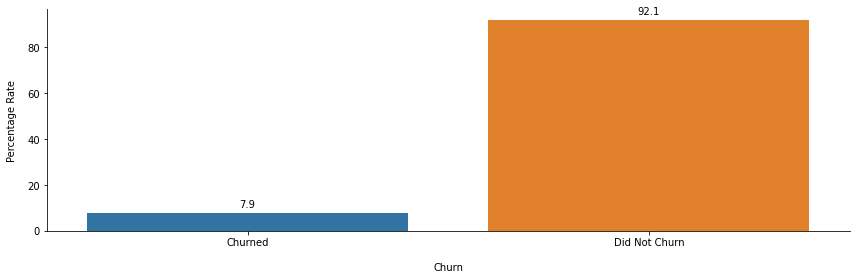

In [89]:
# Plotting the curn vs non-churn customers.
plt.figure(figsize = (12, 4))

length = len(telecom_df)
ax = sns.barplot(x = ['Churned','Did Not Churn'], y = [pos/length * 100,neg/length * 100])
plt.xlabel("Churn", labelpad = 15)
plt.ylabel('Percentage Rate', labelpad = 10)

# Call Custom Function
annotate_graph(ax)


sns.despine()
plt.tight_layout()
plt.show()

### Observation

- Data is highly imbalanced as the percentage of churn customers is only 7.9 %.
- This data imbalance needs to be handled before building model.

In [90]:
# Getting the list of all columns
list(telecom_df.columns)

['arpu_6',
 'arpu_7',
 'arpu_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'vol_2g_mb_6',
 'vol_2g_mb_7',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'vol_3g_mb_7',
 'vol_3g_mb_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly

[]

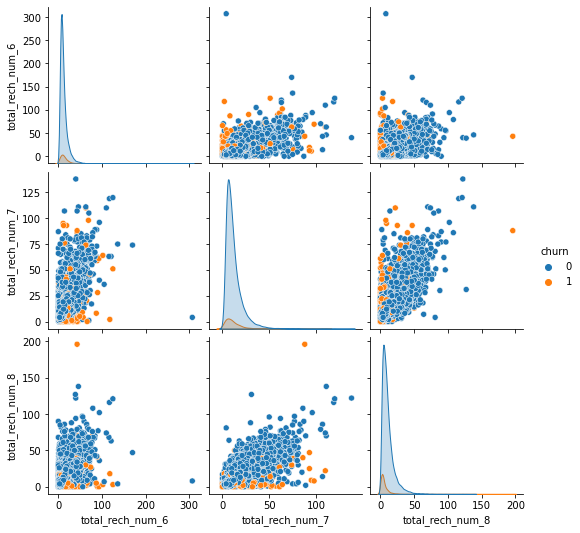

In [91]:
# Plotting Total Recharge Number for June, July, August

total_recharge_number = ['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', "churn"]

sns.pairplot(telecom_df[total_recharge_number], hue="churn")
plt.plot()

[]

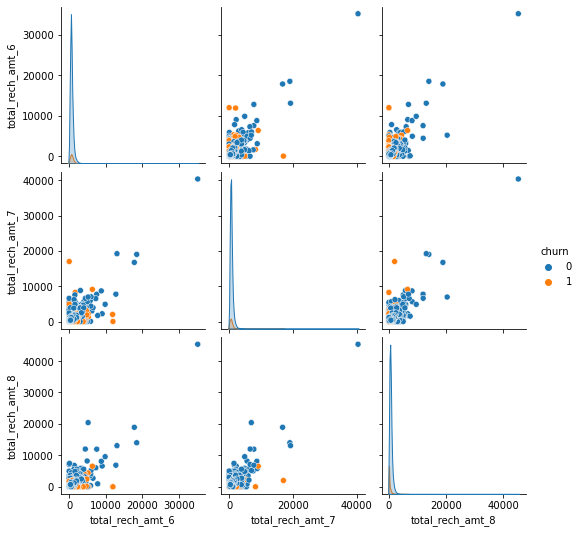

In [92]:
# Plotting Total Recharge Amount for June, July, August

total_recharge_number = ['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',"churn"]

sns.pairplot(telecom_df[total_recharge_number], hue="churn")
plt.plot()


In [93]:
# Defining a funtion to add percentage label
def annotate_graph_perc(ax):
    total_height=0.0
    
    for bar in ax.patches:
        total_height=total_height+bar.get_height()
        
    for bar in ax.patches:         
        ax.annotate(format((bar.get_height()/total_height * 100), '.1f'),                    
                    (bar.get_x() + bar.get_width() / 2,  bar.get_height()),                    
                    ha='center', va='center',                    
                    size=10, xytext=(0, 8),                    
                    textcoords='offset points')
    return ax

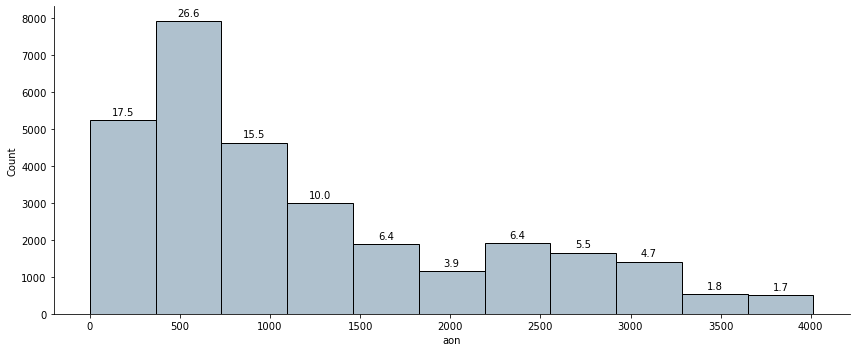

In [94]:
# Plotting the histogram for aon column
plt.figure(figsize=(12,5))

ax = sns.histplot(telecom_df.aon, bins=range(0,telecom_df.aon.max(),365),color="#95adbe")

annotate_graph_perc(ax)
sns.despine()
plt.tight_layout()



plt.show()

In [95]:
# Checking for the vital stats of the aon column.
# This column will specify the Age on network - 
# number of days the customer is using the operator network
print(telecom_df.aon.describe())

count    29824.000000
mean      1211.066658
std        958.051635
min        180.000000
25%        461.000000
50%        849.000000
75%       1761.250000
max       4321.000000
Name: aon, dtype: float64


### Observation

- From the data dictionary we know that aon column will specify the Age on network - number of days the customer is using the operator T network. 
- The newest High Value Customer is 180 days old.
- Majority of the users are near 500 days old mark.
- On average, high value customers are 1200 days old.
- The oldest high value customres are more than 11 years old.

In [96]:
# Extracting numerical columns from the telecom_df data frame.
numerical_cols = telecom_df.select_dtypes(include = np.number).columns.to_list()

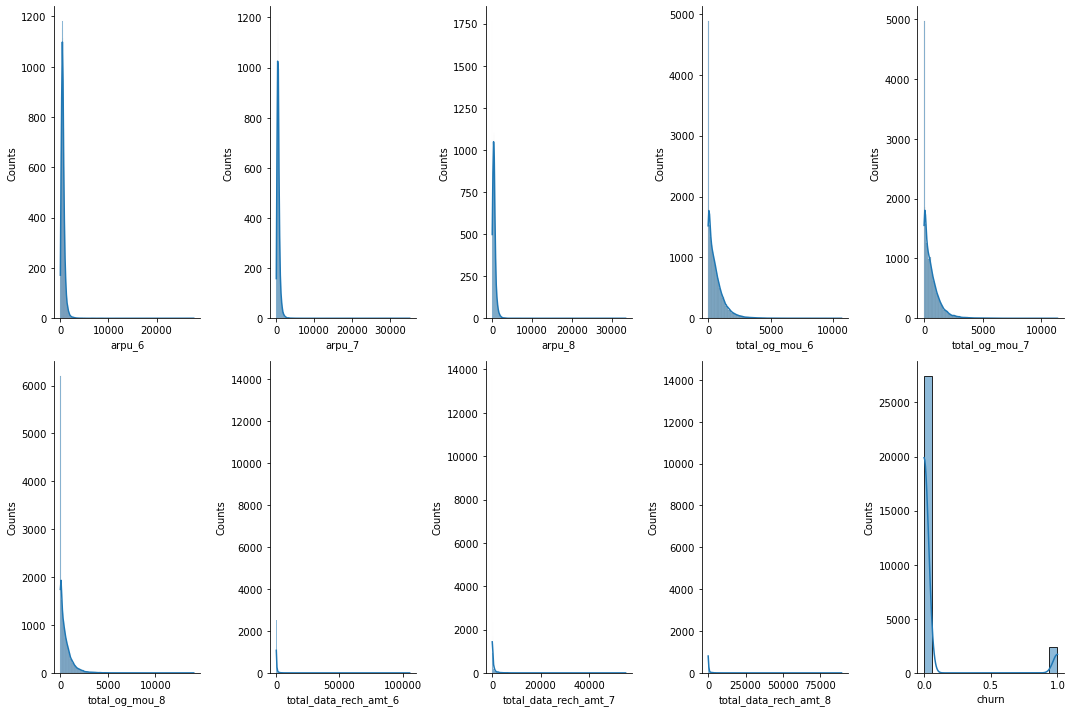

In [97]:
# Univariate Plot Analysis of 'arpu_6','arpu_7','arpu_8','total_og_mou_6',
# 'total_og_mou_7','total_og_mou_8','total_data_rech_amt_6','total_data_rech_amt_7','total_data_rech_amt_8'.

counter = 1

plt.figure(figsize = (15, 10))
columns = ['arpu_6','arpu_7','arpu_8','total_og_mou_6','total_og_mou_7','total_og_mou_8','total_data_rech_amt_6',
        'total_data_rech_amt_7','total_data_rech_amt_8','churn']
for col_list in columns:
    
    plt.subplot(2, 5, counter)
    ax = sns.histplot(x = col_list,data = telecom_df , kde = True)
    plt.xlabel(col_list)
    plt.ylabel('Counts')

    counter += 1


sns.despine()
plt.tight_layout()
plt.show()

In [98]:
# Calculating the skew value for the numerical data.
skew_value = list(skew(telecom_df[numerical_cols]))
skew_results_df = pd.DataFrame({"columns":numerical_cols,'skew_value_before':skew_value})
skew_results_df

,columns,skew_value_before
0,arpu_6,12.125986
1,arpu_7,17.696551
2,arpu_8,15.417124
3,total_og_mou_6,2.514904
4,total_og_mou_7,2.610310
...,...,...
63,vbc_3g_6,5.690933
64,total_data_rech_amt_6,22.711564
65,total_data_rech_amt_7,10.955301
66,total_data_rech_amt_8,19.117894


### Observations
- The above histogram shows that most of the values are not normally distributed and is positively skewed.
- The skewness calculated above for numerical columns will be interpreted based on below rules:

        skewness = 0 : normally distributed.
        skewness > 0 : more weight in the left tail of the distribution.
        skewness < 0 : more weight in the right tail of the distribution. 
        
- As we can see form above for all the numerical columns skewness values are > 0 which means its not normally distributed.

# Bivariate and multivariate analysis

In [99]:
# Defining the function to create the plot of columns with the target variable.
def plot_bivariate_boxplot(y_axis):
    
    plt.figure(figsize = (15, 5))
    
    xlabel = "Churn"
    x_axis = "churn"
    
    title_1 = "Month 6 - " + xlabel
    title_2 = "Month 7 - " + xlabel
    title_3 = "Month 8 - " + xlabel
    
    print("\nData Visualization of churn vs " + y_axis)

    # Subplot - 1
    plt.subplot(1, 3, 1)

    sns.boxplot(x = x_axis, y = y_axis + "_6", hue = "churn", data = telecom_df, showfliers = False)


    # Subplot - 2
    plt.subplot(1, 3, 2)

    sns.boxplot(x = x_axis, y = y_axis + "_7", hue = "churn", data = telecom_df, showfliers = False)

    # Subplot - 3
    plt.subplot(1, 3, 3)

    sns.boxplot(x = x_axis, y = y_axis + "_8", hue = "churn", data = telecom_df, showfliers = False)

    
    plt.subplots_adjust(wspace = 0.4)
    sns.despine()
    plt.tight_layout()
    plt.show()


Data Visualization of churn vs arpu


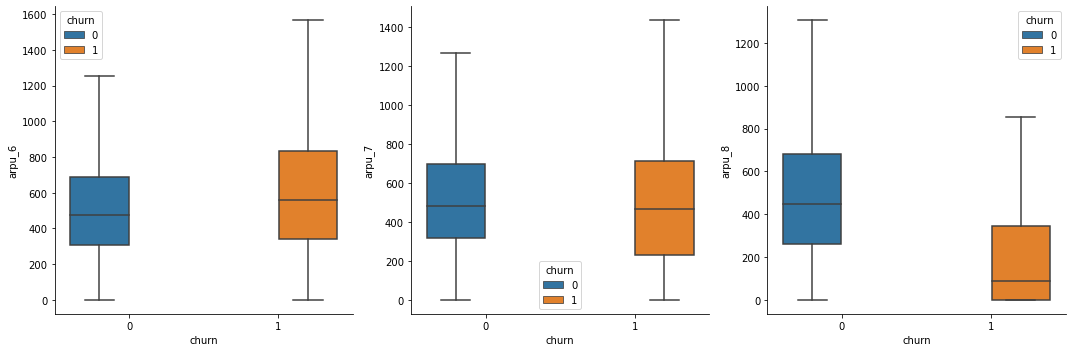


Data Visualization of churn vs total_og_mou


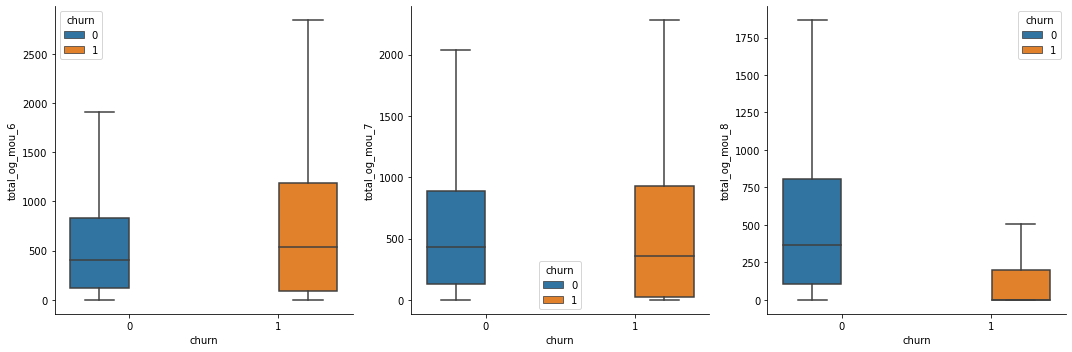


Data Visualization of churn vs total_ic_mou


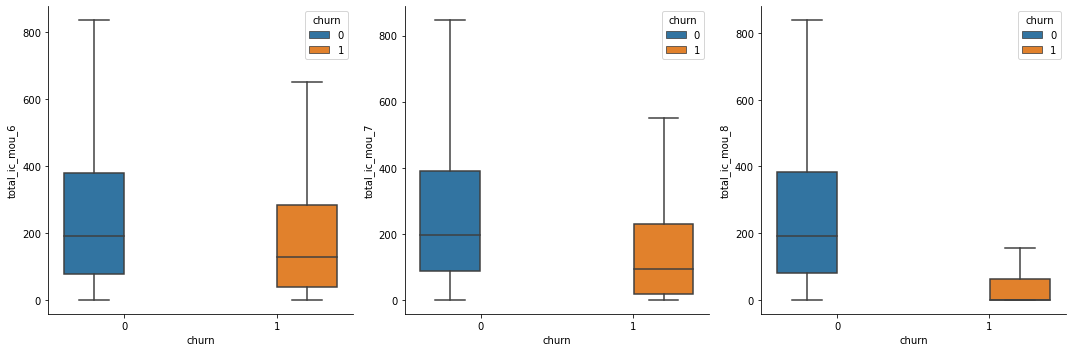


Data Visualization of churn vs total_rech_num


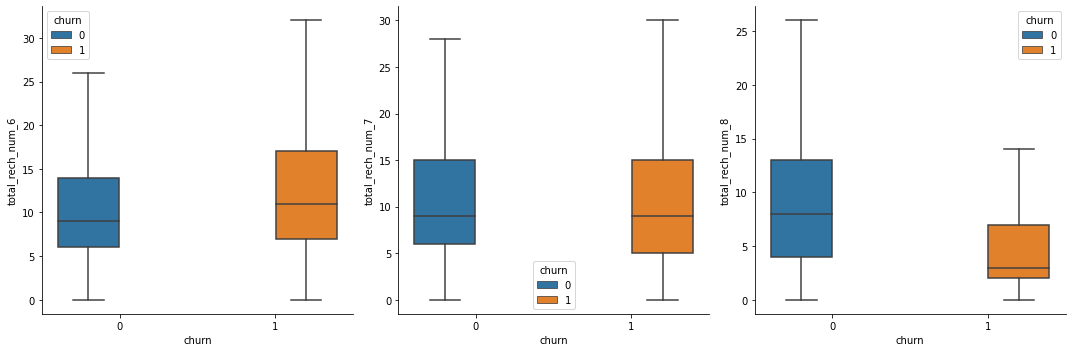

In [100]:
# Plot showing the relationship between churn vs arpu,churn vs total_og_mou,churn vs total_rech_num
plot_bivariate_boxplot("arpu")

plot_bivariate_boxplot("total_og_mou")

plot_bivariate_boxplot("total_ic_mou")

plot_bivariate_boxplot("total_rech_num")



Data Visualization of churn vs total_rech_amt


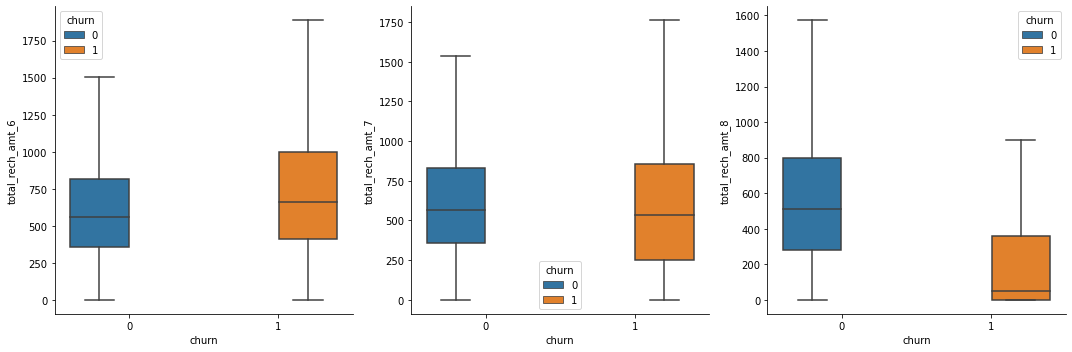


Data Visualization of churn vs total_rech_data


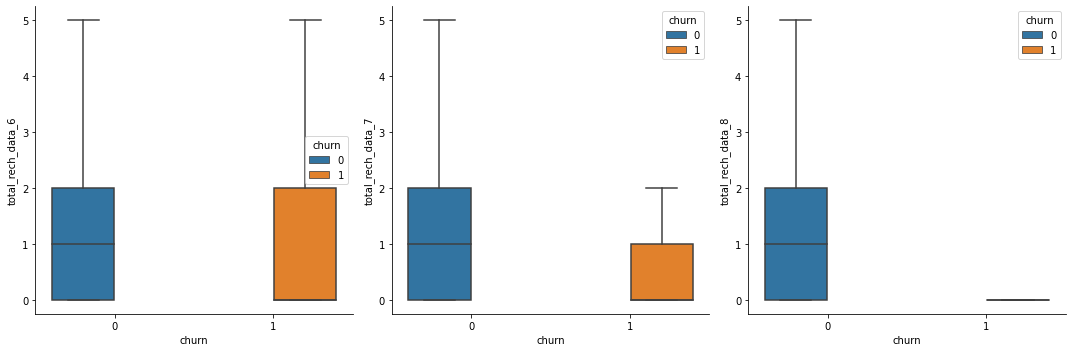


Data Visualization of churn vs vol_2g_mb


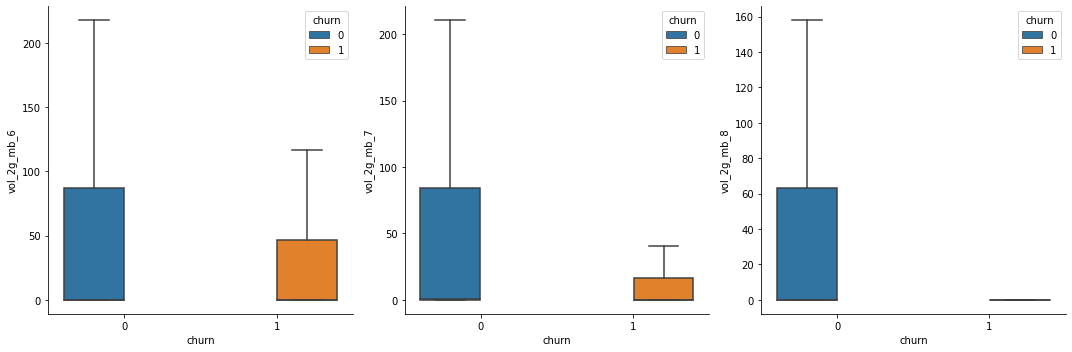


Data Visualization of churn vs vol_3g_mb


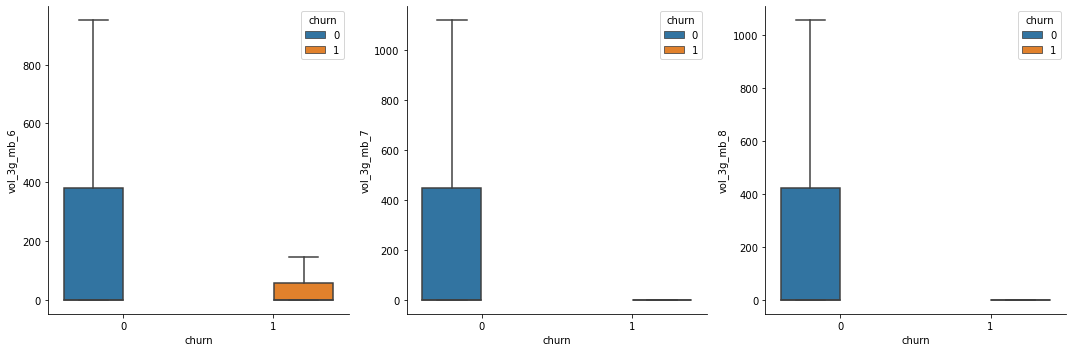

In [101]:
# Bivariate analysis using churn vs total_rech_amt,churn vs total_rech_data,churn vs vol_2g_mb,churn vs vol_3g_mb
plot_bivariate_boxplot("total_rech_amt")

plot_bivariate_boxplot("total_rech_data")

plot_bivariate_boxplot("vol_2g_mb")

plot_bivariate_boxplot("vol_3g_mb")



Data Visualization of churn vs vbc_3g


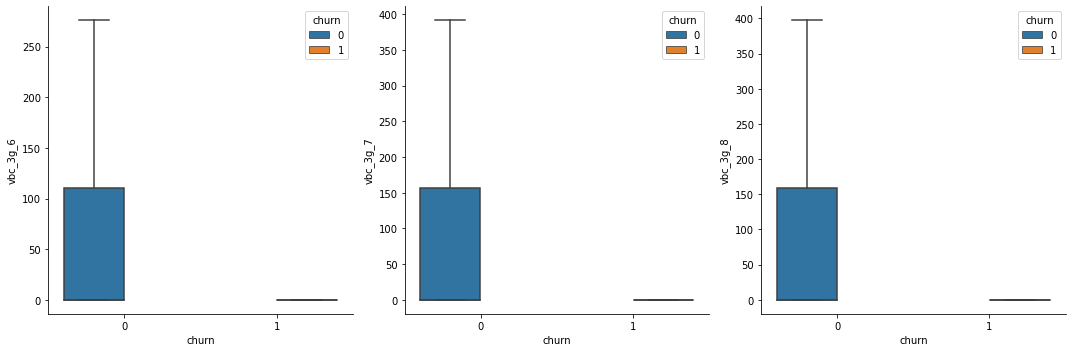


Data Visualization of churn vs total_data_rech_amt


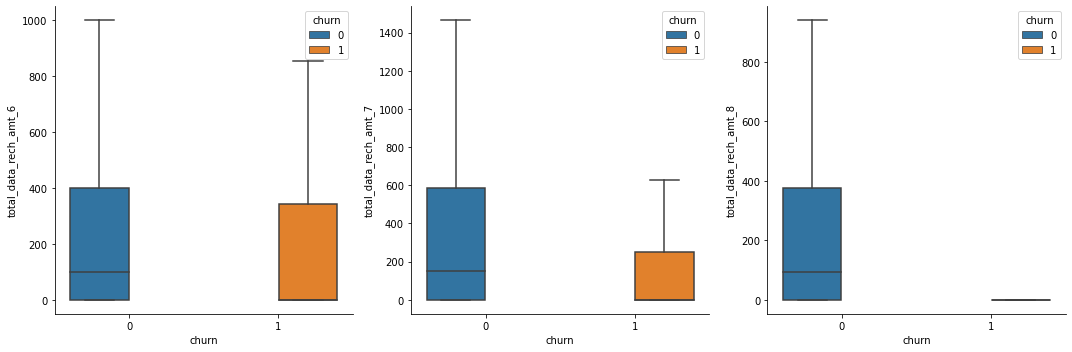

In [102]:
# Bivariate analysis using churn vs vbc_3g,churn vs total_data_rech_amt.
plot_bivariate_boxplot("vbc_3g")

plot_bivariate_boxplot("total_data_rech_amt")

### Observations:

- There is a drop in the columns for data in August (Action Phase) for churned customers. 
- This might act as an early warning to the company and can opt to give some offers to better retention of such customer.
- The average revenue of the potential churn customer almost same with non-churn customer but reduces drastically in the action (August) month. The same trend is seen for the outgoing calls,incoming calls, inter net recharge, total amount of talk time recharge. The company must consider such behaviour as churn indication for such customers and should take appropriate action.

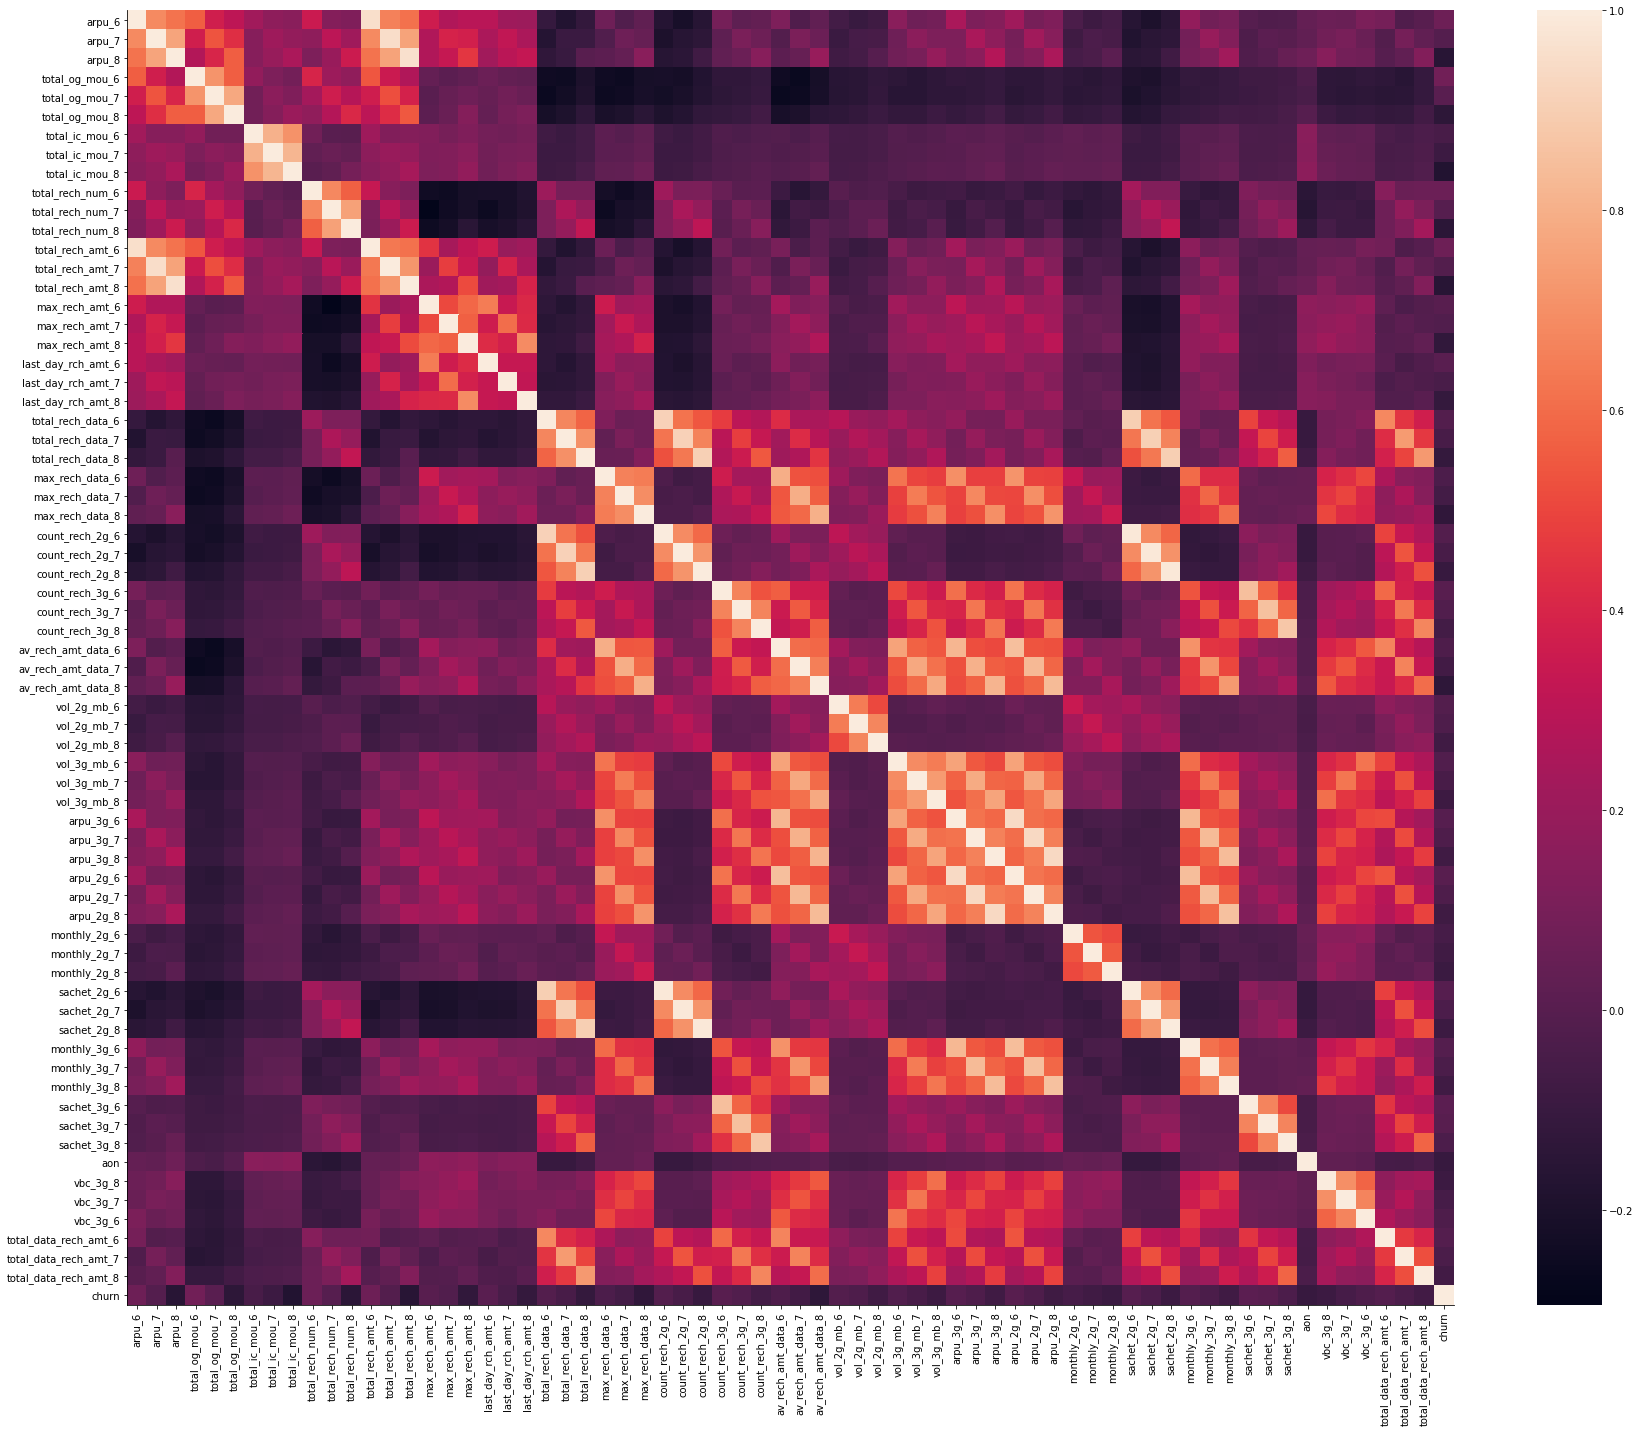

In [103]:
# Plotting the co-relation matrix for the data frame.
plt.figure(figsize = (25, 20))

sns.heatmap(telecom_df.corr())

sns.despine()
plt.tight_layout()

plt.show()



In [104]:
# Top Five negatively correlated pairs
telecom_df.corr().unstack().sort_values().drop_duplicates().head(5)

total_rech_num_7    max_rech_amt_6       -0.294941
av_rech_amt_data_7  total_og_mou_6       -0.263187
total_og_mou_7      av_rech_amt_data_6   -0.261564
total_rech_data_6   total_og_mou_7       -0.256923
max_rech_data_6     total_og_mou_7       -0.253639
dtype: float64

In [105]:
# Top Five positively correlated pairs
telecom_df.corr().unstack().sort_values().drop_duplicates().tail(5)

total_rech_amt_8  arpu_8             0.963979
sachet_2g_6       count_rech_2g_6    0.984860
sachet_2g_7       count_rech_2g_7    0.986406
sachet_2g_8       count_rech_2g_8    0.987167
arpu_6            arpu_6             1.000000
dtype: float64

## Corelation of churn with other variables

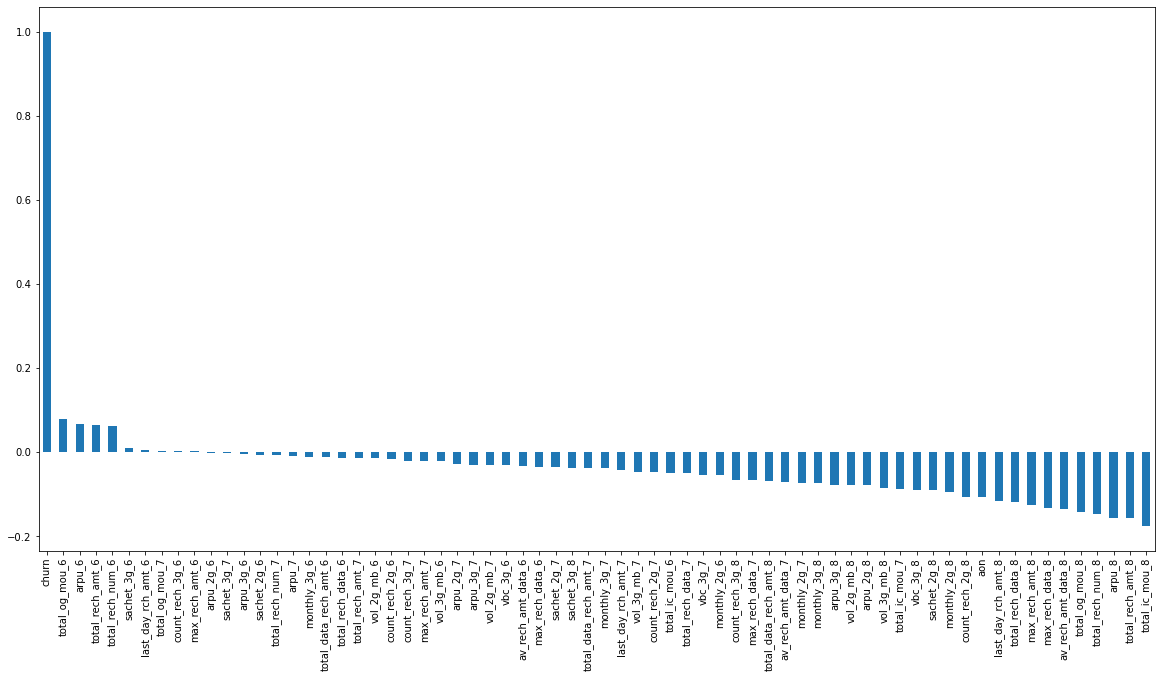

In [106]:
# Creating bar chart for showing co-relation of all variables with churn.
plt.figure(figsize=(20,10))
telecom_df.corr()['churn'].sort_values(ascending = False).plot(kind = 'bar')
plt.show()

### Observations
- Outgoing Calls for Month 6 & 7, Outgoing calls in Roaming are positively correlated with Churn while Revenue, total recharge data,outgoing calls,incoming calls for 8th Month are negatively correlated.

## Churn Vs Max Recharge Amount

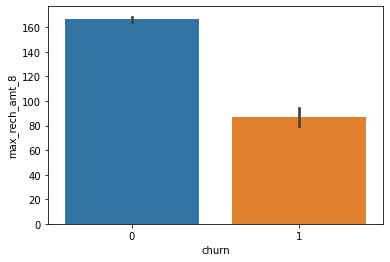

In [107]:
# Plotting the churn with max_rech_amt_8
sns.barplot(x = 'churn',y = 'max_rech_amt_8',data = telecom_df)
plt.show()

### Observations
- The churned customers recharge with less amount.
- Hence we can conclude that customers who recharge with less amount are more likely to churn.

# Outlier treatment

## Method 1 Standard Deviation Method

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

In [108]:
# calculate summary statistics
data = telecom_df[numerical_cols]
data_mean, data_std = np.mean(data), np.std(data)
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = telecom_df[((data < lower) | (data > upper)).any(axis=1)]
print('Number of identified outliers: %d' % len(outliers))

Number of identified outliers: 11422


In [109]:
# remove outliers
outliers_removed = telecom_df[~((data < lower) | (data > upper)).any(axis=1)]
print('Non-outlier observations: %d' % len(outliers_removed))

Non-outlier observations: 18402


## Method 2 IQR method

The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5.

In [110]:
# Calculating Q1,Q2 and Q3
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR[:10])

arpu_6              388.73775
arpu_7              387.27700
arpu_8              428.74500
total_og_mou_6      740.96250
total_og_mou_7      774.34750
total_og_mou_8      702.17000
total_ic_mou_6      299.49250
total_ic_mou_7      298.82000
total_ic_mou_8      300.60750
total_rech_num_6      9.00000
dtype: float64


In [111]:
# Removing the outliers after calculating IQR.
outliers_removed_IQR = telecom_df[~((data < (Q1 - 1.5 * IQR)) 
                                    |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
print('Non-outlier observations: %d' % len(outliers_removed_IQR))

Non-outlier observations: 5243


## Observations
- It is seen form the above that if we choose to remove outliers there is huge data loss.
- We will not be left with enough data for training.
## Conclusion
- We will proceed with model building without removing outliers and use RobustScaler for scaling data which is resistent to outliers.

# Modelling

In [112]:
import sklearn.preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Train Test Split

In [113]:
X = telecom_df.drop('churn', axis = 1)
y = telecom_df[['churn']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, 
                                                    random_state = 100, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20876, 73)
(20876, 1)
(8948, 73)
(8948, 1)


In [114]:
# Normalize the data 

# Robust Scaler uses Scale features using statistics that are robust to outliers
scaler = RobustScaler()

scaled_data = scaler.fit_transform(X_train)

X_train = pd.DataFrame(data = scaled_data, index = X_train.index, columns = X_train.columns)
X_test = pd.DataFrame(data = scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

# Handling Imbalanced Data

As a part of pre-processing stage of ML pipelines prior, the following algorithms will be used for handling imbalanced dataset.

1. Undersampling
 - Random undersampling


2. Oversampling
 - Random oversampling: generates new samples by random resampling with replacement of under represented class
 - Synthetic Minority Oversampling (SMOTE)


3. Combined over and under sampling
 - SMOTEENN
 - SMOTETomek

**Informed Over Sampling: Synthetic Minority Over-sampling Technique**

This technique is followed to avoid overfitting which occurs when exact replicas of minority instances are added to the main dataset. A subset of data is taken from the minority class as an example and then new synthetic similar instances are created. These synthetic instances are then added to the original dataset. The new dataset is used as a sample to train the classification models.

**Advantages**
- Mitigates the problem of overfitting caused by random oversampling as synthetic examples are generated rather than replication of instances
- No loss of useful information

In [115]:
(y_train==1).sum()[0]

1655

In [116]:
print("Before OverSampling, counts of label '1': {}".format((y_train==1).sum()[0]))
print("Before OverSampling, counts of label '0': {} \n".format((y_train==0).sum()[0]))

y_train_1 = (y_train==1).sum()[0]
print("Before OverSampling, churn event rate : {}% \n".format(round(y_train_1/len(y_train)*100,2)))

Before OverSampling, counts of label '1': 1655
Before OverSampling, counts of label '0': 19221 

Before OverSampling, churn event rate : 7.93% 



In [117]:
sm = SMOTE(random_state=27, sampling_strategy=1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [118]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format((y_train_res==1).sum()[0]))
print("After OverSampling, counts of label '0': {}".format((y_train_res==0).sum()[0]))


y_train_1_res = (y_train_res==1).sum()[0]
print("After OverSampling, churn event rate : {}% \n".format(round(y_train_1_res/len(y_train_res)*100,2)))

After OverSampling, the shape of train_X: (38442, 73)
After OverSampling, the shape of train_y: (38442, 1) 

After OverSampling, counts of label '1': 19221
After OverSampling, counts of label '0': 19221
After OverSampling, churn event rate : 50.0% 



# Principal Component Analysis

In [119]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(random_state=42)

In [120]:
#Doing the PCA on the train data
pca.fit(X_train_res)

PCA(random_state=42)

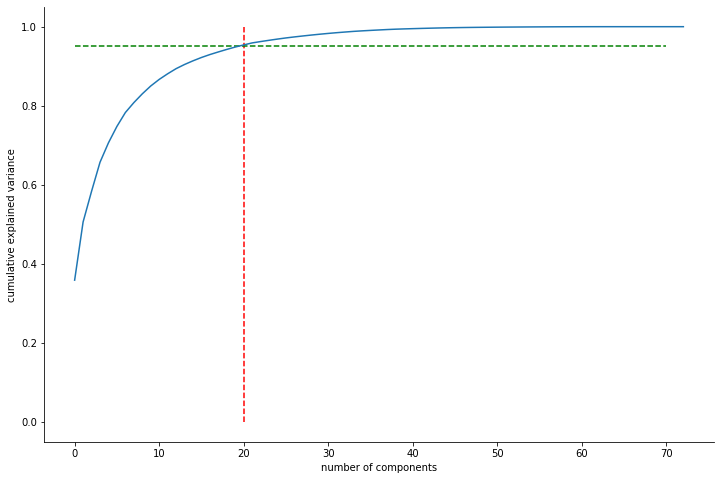

In [121]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.vlines(x = 20,ymax = 1,ymin = 0,colors = 'r',linestyles = '--')
plt.hlines(y = 0.95, xmax = 70,xmin = 0,colors = 'g',linestyles = '--')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

sns.despine()
plt.show()

### Observation

Looks like 20 components are explaining 95% of the varaince. 
- Confirming this using mentioning the amount of variance we want to be explained

In [122]:
pca_again = PCA(0.95)

In [123]:
X_train_pca = pca_again.fit_transform(X_train_res)

In [124]:
X_train_pca.shape

(38442, 21)

In [125]:
# Tranforming X_Test
X_test_pca = pca_again.transform(X_test)
X_test_pca.shape

(8948, 21)

### Observation

- Proving our observation, 21 columns are enough to explain 95% of the variance in dataset.
- This mean that 95% of the information is present in 21 columns instead of 72 columns.

# Defining Functions for Modelling

In [126]:
# Defining the function to plot the ROC Curve

def draw_roc (actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False)
    
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)"%auc_score)
    
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate or [1 - True Negative Rate]")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating charactersitc example")
    plt.legend(loc="lower right")
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    return fpr, tpr, thresholds

In [127]:
metricsdataframe=pd.DataFrame(columns=['Model',
                                       'Train/Test',
                                       'Roc_auc_score',
                                       'Sensitivity',
                                       'Specificity',
                                      'FPR',
                                      'Positive predictive value',
                                      'Negative Predictive value',
                                      'Precision'])
metricsdataframe

,Model,Train/Test,Roc_auc_score,Sensitivity,Specificity,FPR,Positive predictive value,Negative Predictive value,Precision


In [128]:
# Defining function to get the evaluation metrics of the models.
def getModelMetrics(actual_churn=False,pred_churn=False,model_name='',train_or_test=''):

    confusion = metrics.confusion_matrix(actual_churn, pred_churn)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    

    
    Roc_auc_score=round(metrics.roc_auc_score(actual_churn,pred_churn),2)
    # Let's see the sensitivity of our logistic regression model
    Sensitivity=round((TP / float(TP+FN)),2)
    # Let us calculate specificity
    Specificity=round((TN / float(TN+FP)),2)
    # Calculate false postive rate - predicting churn when customer does not have churned
    FPR=round((FP/ float(TN+FP)),2)
    # positive predictive value 
    PositivePredictiveValue=round((TP / float(TP+FP)),2)
    # Negative predictive value
    NegativePredictiveValue=round((TN / float(TN+ FN)),2)
    # sklearn precision score value 
    Precision=round(metrics.precision_score(actual_churn, pred_churn ),2)
    
    
    print("Roc_auc_score : {}".format(metrics.roc_auc_score(actual_churn,pred_churn)))
    # Let's see the sensitivity of our logistic regression model
    print('Sensitivity/Recall : {}'.format(TP / float(TP+FN)))
    # Let us calculate specificity
    print('Specificity: {}'.format(TN / float(TN+FP)))
    # Calculate false postive rate - predicting churn when customer does not have churned
    print('False Positive Rate: {}'.format(FP/ float(TN+FP)))
    # positive predictive value 
    print('Positive predictive value: {}'.format(TP / float(TP+FP)))
    # Negative predictive value
    print('Negative Predictive value: {}'.format(TN / float(TN+ FN)))
    # sklearn precision score value 
    print('sklearn precision score value: {}'.format(metrics.precision_score(actual_churn, pred_churn )))
    
    data_list=[model_name,train_or_test,Roc_auc_score,Sensitivity,Specificity,FPR,PositivePredictiveValue,NegativePredictiveValue,Precision]
    
    series_metrics=pd.Series(data_list,index=metricsdataframe.columns)
    
    return series_metrics
    

In [129]:
# Defining function to write the evaluation metrics of the models into data frame.
def WriteModelMetrics(series_metrics,metricsdataframe):
    metricsdataframe = metricsdataframe.append(series_metrics,ignore_index=True)
    return metricsdataframe

In [130]:
# Function to find the optimal cutoff for classifing as churn/non-churn
def findOptimalCutoff(df):
    
    # Let's create columns with different probability cutoffs 
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i] = df.churn_Prob.map( lambda x: 1 if x > i else 0)
        
    
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    from sklearn.metrics import confusion_matrix
    
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    for i in num:
        cm1 = metrics.confusion_matrix(df.churn, df[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)
    
    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.figure(figsize=(7,5))
    plt.tight_layout()
    sns.despine()
    plt.show()

In [131]:
# Calculating VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Defining a function to give VIF value 
def vif_cal(X):     
    vif = pd.DataFrame() 
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]    
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    return vif


In [132]:
# This method will result in the calculation of predicted value of the churn column.
def predictChurnWithProb(model,X,y,prob,model_name='',train_or_test=''):
    
    # predict
    pred_probs = model.predict_proba(X)[:,1]
    
    y_df= pd.DataFrame({'churn':y.churn, 'churn_Prob':pred_probs})
    # Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
    y_df['final_predicted'] = y_df.churn_Prob.map( lambda x: 1 if x > prob else 0)
    # Let's see the head
    series_metrics=getModelMetrics(y_df.churn,y_df.final_predicted,model_name,train_or_test)
    return y_df,series_metrics

In [133]:
# This method will perform cross-validation and the display the model report.
def modelfit(alg, X_train, y_train, performCV=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.roc_auc_score(y_train, dtrain_predictions))
    print ("Recall/Sensitivity : %.4g" % metrics.recall_score(y_train, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        

In [134]:
# This method will plot accuracy of the model with the max_depth of decision tree.
def plot_traintestAcc(score,param):
    scores = score
    # plotting accuracies with max_depth
    plt.figure()
    plt.plot(scores["param_"+param], 
    scores["mean_train_score"], 
    label="training accuracy")
    plt.plot(scores["param_"+param], 
    scores["mean_test_score"], 
    label="test accuracy")
    plt.xlabel(param)
    plt.ylabel("f1")
    plt.legend()
    plt.show()

In [135]:
# This method will plot accuracy of the random forest model.
def random_forst_feature_graph(grid_search, param):
    scores = grid_search.cv_results_
    plt.figure(figsize=(8,8))
    
    param = "param_"+param
    plt.plot(scores[param], 
             scores["mean_train_score"], 
             label="Training accuracy")

    plt.plot(scores[param], 
             scores["mean_test_score"], 
             label="Test accuracy")

    plt.xlabel(param)
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    sns.despine()
    plt.show()

# 1. Logistic Regression

In [136]:
# Training the model on the train data
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import metrics

In [137]:
# Creating Train-Test variables for Logistic Regression
X_train_lr = pd.DataFrame(X_train_pca)
y_train_lr = pd.DataFrame(y_train_res)
X_test_lr = pd.DataFrame(X_test_pca)
y_test_lr = y_test

In [138]:
logml = sm.GLM(y_train_lr, (sm.add_constant(X_train_lr)), family = sm.families.Binomial())
logml.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38442
Model:                            GLM   Df Residuals:                    38420
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18153.
Date:                Tue, 25 May 2021   Deviance:                       36306.
Time:                        15:29:14   Pearson chi2:                 6.36e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1411      0.014     -9.964      0.000      -0.169      -0.113
0             -0.0628      0.002    -36.053      0.000      -0.066      -0.059
1             -0.0976      0.003    -31.798      0.000      -0.104      -0.092
2              0.0973      0.003     30.202      0.000       0.091       0.104
3             -0.0049      0.004     -1.149      0.250      -0.013       0.003
4             -0.0030      0.004     -0.807      0.420      -0.010       0.004
5              0.1673      0.005     34.228      0.000       0.158       0.177
6             -0.1822      0.006    -31.235      0.000      -0.194      -0.171
7             -0.1198      0.006    -19.416      0.000      -0.132      -0.108
8              0.0269      0.008      3.550      0.000       0.012       0.042
9             -0.0485      0.006     -7.634      0.000      -0.061      -0.036
10             0.0415      0.007      6.153      0.000       0.028       0.055
11             0.0602      0.007      8.270      0.000       0.046       0.074
12            -0.2021      0.008    -24.889      0.000      -0.218      -0.186
13             0.2029      0.009     22.984      0.000       0.186       0.220
14            -0.3769      0.009    -40.351      0.000      -0.395      -0.359
15            -0.4230      0.011    -39.552      0.000      -0.444      -0.402
16            -0.2062      0.011    -18.574      0.000      -0.228      -0.184
17             0.4210      0.012     33.862      0.000       0.397       0.445
18             0.1325      0.011     11.679      0.000       0.110       0.155
19             0.3615      0.012     29.928      0.000       0.338       0.385
20            -0.3239      0.013    -24.674      0.000      -0.350      -0.298
==============================================================================
"""

In [139]:
# Checking for the VIF of the train data.
vif = vif_cal(X_train_lr) 
vif


,Features,VIF
0,0,1.0
11,11,1.0
19,19,1.0
18,18,1.0
17,17,1.0
16,16,1.0
15,15,1.0
14,14,1.0
13,13,1.0
12,12,1.0


### Observation
- VIF value of all the columns are 1 which is good number, so we will consider the p-value for dropping the variables.
- p-value of col "4" = 0.420
- p-value of col "3" = 0.250

Need to drop them one by one. Let's start by dropping column "4"

In [140]:
# Dropping column 4 and building the model.
X_train_lr.drop(4, axis=1, inplace=True)

In [141]:
# Fitting the model after dropping column 4.
logml = sm.GLM(y_train_lr, (sm.add_constant(X_train_lr)), family = sm.families.Binomial())
logml.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38442
Model:                            GLM   Df Residuals:                    38421
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18153.
Date:                Tue, 25 May 2021   Deviance:                       36307.
Time:                        15:29:15   Pearson chi2:                 6.40e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1417      0.014    -10.016      0.000      -0.169      -0.114
0             -0.0629      0.002    -36.076      0.000      -0.066      -0.060
1             -0.0978      0.003    -31.887      0.000      -0.104      -0.092
2              0.0975      0.003     30.027      0.000       0.091       0.104
3             -0.0048      0.004     -1.123      0.261      -0.013       0.004
5              0.1672      0.005     34.128      0.000       0.158       0.177
6             -0.1826      0.006    -31.341      0.000      -0.194      -0.171
7             -0.1197      0.006    -19.395      0.000      -0.132      -0.108
8              0.0264      0.008      3.475      0.001       0.012       0.041
9             -0.0485      0.006     -7.607      0.000      -0.061      -0.036
10             0.0416      0.007      6.132      0.000       0.028       0.055
11             0.0599      0.007      8.197      0.000       0.046       0.074
12            -0.2018      0.008    -24.815      0.000      -0.218      -0.186
13             0.2030      0.009     22.964      0.000       0.186       0.220
14            -0.3765      0.009    -40.293      0.000      -0.395      -0.358
15            -0.4229      0.011    -39.543      0.000      -0.444      -0.402
16            -0.2061      0.011    -18.547      0.000      -0.228      -0.184
17             0.4203      0.012     33.631      0.000       0.396       0.445
18             0.1322      0.011     11.635      0.000       0.110       0.154
19             0.3612      0.012     29.333      0.000       0.337       0.385
20            -0.3243      0.013    -24.566      0.000      -0.350      -0.298
==============================================================================
"""

In [142]:
# Checking with VIF again.
vif = vif_cal(X_train_lr) 
vif

,Features,VIF
0,0,1.0
1,1,1.0
18,19,1.0
17,18,1.0
16,17,1.0
15,16,1.0
14,15,1.0
13,14,1.0
12,13,1.0
11,12,1.0


### Observation
- p-value of col "3" = 0.261

Need to drop col 3. 

In [143]:
# Dropping column 3 and building the model.
X_train_lr.drop(3, axis=1, inplace=True)

In [144]:
# Fitting the model after dropping column 3.
logml = sm.GLM(y_train_lr, (sm.add_constant(X_train_lr)), family = sm.families.Binomial())
logml.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38442
Model:                            GLM   Df Residuals:                    38422
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18154.
Date:                Tue, 25 May 2021   Deviance:                       36308.
Time:                        15:29:16   Pearson chi2:                 6.73e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1422      0.014    -10.043      0.000      -0.170      -0.114
0             -0.0632      0.002    -36.130      0.000      -0.067      -0.060
1             -0.0981      0.003    -31.763      0.000      -0.104      -0.092
2              0.0974      0.003     29.671      0.000       0.091       0.104
5              0.1674      0.005     34.104      0.000       0.158       0.177
6             -0.1834      0.006    -31.221      0.000      -0.195      -0.172
7             -0.1208      0.006    -19.847      0.000      -0.133      -0.109
8              0.0229      0.007      3.181      0.001       0.009       0.037
9             -0.0468      0.006     -7.548      0.000      -0.059      -0.035
10             0.0421      0.007      6.194      0.000       0.029       0.055
11             0.0586      0.007      8.060      0.000       0.044       0.073
12            -0.2015      0.008    -24.684      0.000      -0.218      -0.186
13             0.2046      0.009     23.287      0.000       0.187       0.222
14            -0.3763      0.009    -40.182      0.000      -0.395      -0.358
15            -0.4230      0.011    -39.542      0.000      -0.444      -0.402
16            -0.2053      0.011    -18.468      0.000      -0.227      -0.183
17             0.4197      0.013     32.771      0.000       0.395       0.445
18             0.1316      0.011     11.599      0.000       0.109       0.154
19             0.3607      0.013     28.791      0.000       0.336       0.385
20            -0.3255      0.013    -24.474      0.000      -0.352      -0.299
==============================================================================
"""

### Observation

All the variables are statiscally significant. 

In [145]:
# Dropping these 2 columns from X_Test as well
X_test_lr.drop(3, axis=1, inplace=True)
X_test_lr.drop(4, axis=1, inplace=True)

In [146]:
lg = LogisticRegression()

In [147]:
modelfit(lg, X_train_lr, y_train_lr)


Model Report
Accuracy : 0.7961
Recall/Sensitivity : 0.8073
AUC Score (Train): 0.866358
CV Score : Mean - 0.8660093 | Std - 0.006652883 | Min - 0.8575484 | Max - 0.8736497


In [148]:
# predictions on Test data
pred_probs_test = lg.predict(X_test_lr)
getModelMetrics(y_test_lr,pred_probs_test)

Roc_auc_score : 0.7731531087053541
Sensitivity/Recall : 0.7545839210155149
Specificity: 0.7917222963951935
False Positive Rate: 0.2082777036048064
Positive predictive value: 0.23767214571301643
Negative Predictive value: 0.9740182171121398
sklearn precision score value: 0.23767214571301643


Model                            
Train/Test                       
Roc_auc_score                0.77
Sensitivity                  0.75
Specificity                  0.79
FPR                          0.21
Positive predictive value    0.24
Negative Predictive value    0.97
Precision                    0.24
dtype: object

In [149]:
print("Accuracy : {}".format(metrics.accuracy_score(y_test_lr,pred_probs_test)))
print("Recall : {}".format(metrics.recall_score(y_test_lr,pred_probs_test)))
print("Precision : {}".format(metrics.precision_score(y_test_lr,pred_probs_test)))

Accuracy : 0.788779615556549
Recall : 0.7545839210155149
Precision : 0.23767214571301643


In [150]:
#Making prediction on the test data
pred_probs_train = lg.predict_proba(X_train_lr)[:,1]

print("roc_auc_score(Train) {:2.2}".format(metrics.roc_auc_score(y_train_lr, pred_probs_train)))

roc_auc_score(Train) 0.87


In [151]:
X_train_lr.shape

(38442, 19)

In [152]:
y_train_lr.shape

(38442, 1)

In [153]:
cut_off_prob=0.5
y_train_df,series_metrics = predictChurnWithProb(lg,X_train_lr,y_train_lr,cut_off_prob)


Roc_auc_score : 0.796082409864211
Sensitivity/Recall : 0.807294105405546
Specificity: 0.784870714322876
False Positive Rate: 0.21512928567712397
Positive predictive value: 0.7895888459189905
Negative Predictive value: 0.8028738690792975
sklearn precision score value: 0.7895888459189905


# Logistic Regression
### Hyper Parameter Tuning


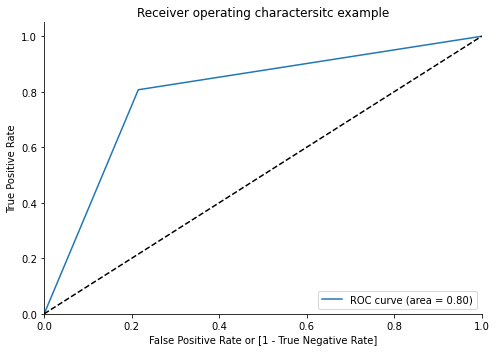

roc_auc_score : 0.80


In [154]:
draw_roc(y_train_df.churn, y_train_df.final_predicted)#draw_roc(y_pred_final.Churn, y_pred_final.predicted)
print("roc_auc_score : {:2.2f}".format(metrics.roc_auc_score(y_train_df.churn, y_train_df.final_predicted)))

In [155]:
#draw_roc(y_pred_final.Churn, y_pred_final.predicted)
print("roc_auc_score : {:2.2f}".format(metrics.roc_auc_score(y_train_df.churn, y_train_df.final_predicted)))

roc_auc_score : 0.80


**Finding Optimal Cutoff Point**
\
\
Since recall or sensitivity is a much more important metrics for churn prediction. A trade off between sensitivity(or recall) and specificity is to be considered in doing so. We will try adjusting the probability threshold which shall lead to higher sensitivity or recall rate.

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.616851  0.974195  0.259508
0.2   0.2  0.685474  0.947193  0.423755
0.3   0.3  0.735185  0.911971  0.558400
0.4   0.4  0.773035  0.866656  0.679413
0.5   0.5  0.796082  0.807294  0.784871
0.6   0.6  0.796941  0.730191  0.863691
0.7   0.7  0.776807  0.635087  0.918527
0.8   0.8  0.698065  0.437542  0.958587
0.9   0.9  0.576817  0.166433  0.987201


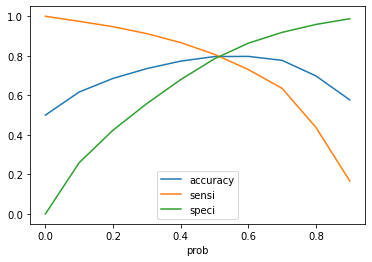

<Figure size 504x360 with 0 Axes>

In [156]:
# finding cut-off with the right balance of the metrices
# sensitivity vs specificity trade-off
findOptimalCutoff(y_train_df)

#### **From the curve above, 0.45 is the optimum point .**


In [157]:
# predicting with the choosen cut-off on TRAIN
cut_off_prob = 0.45
y_train_df,series_metrics = predictChurnWithProb(lg,X_train_lr,y_train_lr,cut_off_prob,model_name='Logistic Regression',train_or_test='TRAIN')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.7860152957702513
Sensitivity/Recall : 0.8390302273554966
Specificity: 0.733000364185006
False Positive Rate: 0.26699963581499403
Positive predictive value: 0.7585963591890493
Negative Predictive value: 0.8199383111214572
sklearn precision score value: 0.7585963591890493


In [158]:
# predicting with the choosen cut-off on TEST
cut_off_prob=0.45
y_train_df,series_metrics = predictChurnWithProb(lg,X_test_lr,y_test_lr,cut_off_prob,model_name='Logistic Regression',train_or_test='TEST')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.7646965625492707
Sensitivity/Recall : 0.7856135401974612
Specificity: 0.7437795849010802
False Positive Rate: 0.2562204150989198
Positive predictive value: 0.20877061469265368
Negative Predictive value: 0.975796178343949
sklearn precision score value: 0.20877061469265368


## Logistic Regression after optimal Cut-off
<br>
- <b>Train Sensitivity  :</b> 83.90%, <b>Train Roc-Auc Score  :</b> 78.60%
<br><br>
- <b>Test Sensitivity   :</b> 78.56%, <b>Test ROC-AUC Score  :</b> 76.46%

# 2. Decision Tree

In [159]:
# Creating Train-Test variables for Decision Tree
X_train_dt = pd.DataFrame(X_train_pca)
y_train_dt = pd.DataFrame(y_train_res)
X_test_dt = pd.DataFrame(X_test_pca)
y_test_dt = y_test

In [160]:
##### Applying Decision Tree Classifier on our principal components with Hyperparameter tuning
dt = DecisionTreeClassifier(class_weight='balanced',
                             max_features='auto',
                             min_samples_split=100,
                             min_samples_leaf=100,
                             max_depth=10,
                             random_state=10)
modelfit(dt, X_train_dt, y_train_dt)


Model Report
Accuracy : 0.7922
Recall/Sensitivity : 0.803
AUC Score (Train): 0.872371
CV Score : Mean - 0.8545799 | Std - 0.004091279 | Min - 0.8501609 | Max - 0.8614539


In [161]:
# make predictions
pred_probs_test = dt.predict(X_test_dt)

#Let's check the model metrices.
getModelMetrics(actual_churn=y_test_dt,pred_churn=pred_probs_test)

Roc_auc_score : 0.7228669726066348
Sensitivity/Recall : 0.6713681241184767
Specificity: 0.774365821094793
False Positive Rate: 0.22563417890520696
Positive predictive value: 0.20385438972162742
Negative Predictive value: 0.9647663692726448
sklearn precision score value: 0.20385438972162742


Model                            
Train/Test                       
Roc_auc_score                0.72
Sensitivity                  0.67
Specificity                  0.77
FPR                          0.23
Positive predictive value     0.2
Negative Predictive value    0.96
Precision                     0.2
dtype: object

In [162]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2,3,5,10,15,20,25,30],
    'min_samples_leaf': range(100, 500, 50),
    'min_samples_split': range(100, 500, 50),
    'max_features': [5,8,10,15,20]
}
# Create a base model
dt = DecisionTreeClassifier(class_weight='balanced',random_state=10)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dt, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1,scoring="f1_weighted")

In [163]:
# Fit the grid search to the data
grid_search.fit(X_train_dt, y_train_dt)

Fitting 3 folds for each of 2560 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4166 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4916 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 5766 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 6716 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:  3.4min finished


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 15, 20, 25, 30],
                         'max_features': [5, 8, 10, 15, 20],
                         'min_samples_leaf': range(100, 500, 50),
                         'min_samples_split': range(100, 500, 50)},
             scoring='f1_weighted', verbose=1)

In [164]:
# printing the optimal accuracy score and hyperparameters
print('We can get recall of',grid_search.best_score_,'using',grid_search.best_params_)

We can get recall of 0.7843413505493624 using {'max_depth': 15, 'max_features': 20, 'min_samples_leaf': 100, 'min_samples_split': 100}


In [165]:
cv_df = pd.DataFrame(grid_search.cv_results_)
cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.068998,3.371748e-07,0.010414,0.014728,2,5,100,100,"{'max_depth': 2, 'max_features': 5, 'min_sampl...",0.664454,0.667977,0.667557,0.666663,0.001571,2433
1,0.070805,1.924688e-03,0.007394,0.003804,2,5,100,150,"{'max_depth': 2, 'max_features': 5, 'min_sampl...",0.664454,0.667977,0.667557,0.666663,0.001571,2433
2,0.076371,9.987335e-03,0.012733,0.006657,2,5,100,200,"{'max_depth': 2, 'max_features': 5, 'min_sampl...",0.664454,0.667977,0.667557,0.666663,0.001571,2433
3,0.074824,1.155962e-02,0.010051,0.000011,2,5,100,250,"{'max_depth': 2, 'max_features': 5, 'min_sampl...",0.664454,0.667977,0.667557,0.666663,0.001571,2433
4,0.068399,4.331070e-03,0.010053,0.000012,2,5,100,300,"{'max_depth': 2, 'max_features': 5, 'min_sampl...",0.664454,0.667977,0.667557,0.666663,0.001571,2433


In [166]:
cv_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1536,0.710168,0.087766,0.010037,0.000009,15,20,100,100,"{'max_depth': 15, 'max_features': 20, 'min_sam...",0.778204,0.786474,0.788345,0.784341,0.004406,1
1537,0.680822,0.032209,0.010038,0.000005,15,20,100,150,"{'max_depth': 15, 'max_features': 20, 'min_sam...",0.778204,0.786474,0.788345,0.784341,0.004406,1
1538,0.669918,0.041160,0.009372,0.000947,15,20,100,200,"{'max_depth': 15, 'max_features': 20, 'min_sam...",0.778204,0.786474,0.788345,0.784341,0.004406,1
1856,0.678706,0.010173,0.011347,0.001859,20,20,100,100,"{'max_depth': 20, 'max_features': 20, 'min_sam...",0.778204,0.786474,0.788345,0.784341,0.004406,1
1857,0.699736,0.017064,0.011412,0.003451,20,20,100,150,"{'max_depth': 20, 'max_features': 20, 'min_sam...",0.778204,0.786474,0.788345,0.784341,0.004406,1


In [167]:
grid_search.best_score_

0.7843413505493624

In [168]:
grid_search.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=15, max_features=20,
                       min_samples_leaf=100, min_samples_split=100,
                       random_state=10)

In [169]:
# model with the best hyperparameters
dt_final = DecisionTreeClassifier(class_weight='balanced',
                             max_depth=15,
                             max_features=20,
                             min_samples_leaf=100, 
                             min_samples_split=100,
                             random_state=10)

In [170]:
modelfit(dt_final,X_train_dt,y_train_dt)


Model Report
Accuracy : 0.8192
Recall/Sensitivity : 0.8428
AUC Score (Train): 0.905801
CV Score : Mean - 0.8757988 | Std - 0.005747674 | Min - 0.866301 | Max - 0.8825897


In [171]:
# make predictions
pred_probs_test = dt_final.predict(X_test_dt)
#Let's check the model metrices.
getModelMetrics(actual_churn=y_test_dt,pred_churn=pred_probs_test)

Roc_auc_score : 0.716057534335219
Sensitivity/Recall : 0.6572637517630465
Specificity: 0.7748513169073916
False Positive Rate: 0.22514868309260833
Positive predictive value: 0.2007755277897458
Negative Predictive value: 0.9633318243549117
sklearn precision score value: 0.2007755277897458


Model                            
Train/Test                       
Roc_auc_score                0.72
Sensitivity                  0.66
Specificity                  0.77
FPR                          0.23
Positive predictive value     0.2
Negative Predictive value    0.96
Precision                     0.2
dtype: object

### Observation

- Recall is only 65.7%.
- We can further improve this recall value by defining some cut-off to predict churn.

In [172]:
# predicting churn with default cut-off 0.5
cut_off_prob = 0.5
y_train_df,series_metrics = predictChurnWithProb(dt_final,X_train_dt,y_train_dt,cut_off_prob)

Roc_auc_score : 0.819182144529421
Sensitivity/Recall : 0.8427761302741793
Specificity: 0.7955881587846626
False Positive Rate: 0.2044118412153374
Positive predictive value: 0.8047992845786963
Negative Predictive value: 0.8349896254231736
sklearn precision score value: 0.8047992845786963


     prob  accuracy     sensi     speci
0.0   0.0  0.589537  1.000000  0.179075
0.1   0.1  0.720202  0.987149  0.453254
0.2   0.2  0.756620  0.969304  0.543936
0.3   0.3  0.792675  0.934863  0.650486
0.4   0.4  0.815254  0.881692  0.748816
0.5   0.5  0.819182  0.842776  0.795588
0.6   0.6  0.813433  0.773217  0.853650
0.7   0.7  0.785885  0.656001  0.915769
0.8   0.8  0.742105  0.525935  0.958275
0.9   0.9  0.667395  0.347224  0.987566


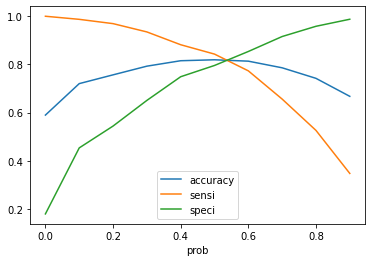

<Figure size 504x360 with 0 Axes>

In [173]:
# finding cut-off with the right balance of the metrices
findOptimalCutoff(y_train_df)

### Observation

- Cutoff seems to be just above 0.5

In [174]:
# predicting churn with cut-off 0.525
cut_off_prob=0.525
y_train_df,series_metrics = predictChurnWithProb(dt_final,X_train_dt,y_train_dt,cut_off_prob,model_name='Decision Tree',train_or_test='TRAIN')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.8188699859528641
Sensitivity/Recall : 0.8339836637011602
Specificity: 0.8037563082045679
False Positive Rate: 0.19624369179543208
Positive predictive value: 0.8095141904858095
Negative Predictive value: 0.8288090128755364
sklearn precision score value: 0.8095141904858095


In [175]:
#Lets see how it performs on test data.
y_test_df,series_metrics= predictChurnWithProb(dt_final,X_test_dt,y_test_dt,cut_off_prob,model_name='Decision Tree',train_or_test='TEST')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.7151493695658835
Sensitivity/Recall : 0.6459802538787024
Specificity: 0.7843184852530647
False Positive Rate: 0.2156815147469353
Positive predictive value: 0.20492170022371364
Negative Predictive value: 0.9626098614628333
sklearn precision score value: 0.20492170022371364


## Decision Tree after HyperParameter Tuning
<br>
- <b>Train Sensitivity  :</b> 83.39%, <b>Train Roc-Auc Score  :</b> 81.88%
<br><br>
- <b>Test Sensitivity   :</b> 64.59%, <b>Test ROC-AUC Score  :</b> 71.451

# 3. Random Forest

In [176]:
# Creating Train-Test variables for Random Forest
X_train_rf = pd.DataFrame(X_train_pca)
y_train_rf = pd.DataFrame(y_train_res)
X_test_rf = pd.DataFrame(X_test_pca)
y_test_rf = y_test

In [177]:
# Fitting a Random Forest without any hypter-parameter tuning

In [178]:
rf = RandomForestClassifier(random_state=42, max_depth=5, n_estimators=20, oob_score=True)

In [179]:
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=5, n_estimators=20, oob_score=True,
                       random_state=42)

In [180]:
rf.oob_score_

0.7761823006087092

In [181]:
# make predictions
pred_probs_test = rf.predict(X_test_rf)

#Let's check the model metrices.
getModelMetrics(actual_churn=y_test_rf,pred_churn=pred_probs_test)

Roc_auc_score : 0.7442266484816872
Sensitivity/Recall : 0.6826516220028209
Specificity: 0.8058016749605534
False Positive Rate: 0.19419832503944653
Positive predictive value: 0.23224568138195778
Negative Predictive value: 0.9672202797202797
sklearn precision score value: 0.23224568138195778


Model                            
Train/Test                       
Roc_auc_score                0.74
Sensitivity                  0.68
Specificity                  0.81
FPR                          0.19
Positive predictive value    0.23
Negative Predictive value    0.97
Precision                    0.23
dtype: object

In [182]:
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'max_depth': [5,10,15,20,25,30],
#     'min_samples_leaf': range(10, 140, 20),
#     'max_features': [5,10,20],
#     'min_samples_split': range(5, 140, 20),
#     'n_estimators':[10,30,50,100,200]
# }

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1,verbose = 100,scoring="f1_weighted")

In [183]:
# Creating param_grid variable as a dictionary of parameters is taking more than a hour to fit.
# We will tune parameters one by one

### Tuning max-depth

In [184]:
parameters = {'max_depth': range(10, 40, 5)}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, parameters, cv=5, scoring="f1_weighted", verbose=1000, return_train_score=True)

grid_search.fit(X_train_rf, y_train_rf)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=10 ....................................................
[CV] .... max_depth=10, score=(train=0.907, test=0.875), total=   6.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[CV] max_depth=10 ....................................................
[CV] .... max_depth=10, score=(train=0.910, test=0.866), total=   6.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s
[CV] max_depth=10 ....................................................
[CV] .... max_depth=10, score=(train=0.908, test=0.878), total=   6.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.8s remaining:    0.0s
[CV] max_depth=10 ....................................................
[CV] .... max_depth=10, score=(train=0.908, test=0.872), total=   6.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(10, 40, 5)},
             return_train_score=True, scoring='f1_weighted', verbose=1000)

In [185]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,8.918607,0.115289,0.119206,0.004272,30,{'max_depth': 30},0.940155,0.937037,0.938597,0.938332,0.939245,0.938673,0.001032,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,8.805411,0.133347,0.118045,0.004047,35,{'max_depth': 35},0.942234,0.933789,0.940548,0.937166,0.936771,0.938102,0.002977,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,8.889282,0.093216,0.118080,0.005432,25,{'max_depth': 25},0.939498,0.932482,0.938070,0.938333,0.935075,0.936692,0.002561,3,0.999805,0.999772,0.999902,0.999642,0.999447,0.999714,0.000157
2,8.726944,0.060627,0.117361,0.003805,20,{'max_depth': 20},0.936637,0.933254,0.936379,0.935334,0.935984,0.935518,0.001214,4,0.995740,0.995513,0.996391,0.994927,0.995122,0.995539,0.000513
1,8.175488,0.059263,0.106491,0.003640,15,{'max_depth': 15},0.928818,0.917504,0.925314,0.925441,0.922841,0.923983,0.003756,5,0.979998,0.980323,0.978925,0.979901,0.979219,0.979673,0.000519
0,6.296629,0.129541,0.081556,0.005729,10,{'max_depth': 10},0.875401,0.865640,0.877983,0.872134,0.874476,0.873127,0.004186,6,0.906730,0.910213,0.907877,0.907712,0.908006,0.908107,0.001145


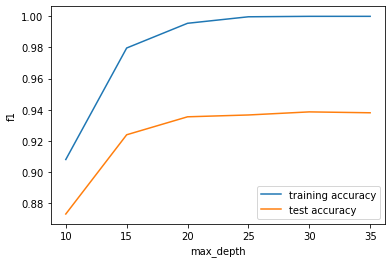

In [186]:
# grid_search.cv_results_

plot_traintestAcc(grid_search.cv_results_,'max_depth')

### Observation

Though 30 max_depth has the highest rank. The accuracy graph stagnates after 25 max_depth

### Tuning n_estimators

In [187]:
parameters = {'n_estimators': range(5, 40, 5)}

rf = RandomForestClassifier(max_depth=25,random_state=10)
grid_search = GridSearchCV(rf, parameters, cv=3, scoring="f1", verbose=100, return_train_score=True)


grid_search.fit(X_train_rf, y_train_rf)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=5 ..................................................
[CV] .. n_estimators=5, score=(train=0.988, test=0.899), total=   0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[CV] n_estimators=5 ..................................................
[CV] .. n_estimators=5, score=(train=0.988, test=0.899), total=   0.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[CV] n_estimators=5 ..................................................
[CV] .. n_estimators=5, score=(train=0.987, test=0.896), total=   0.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[CV] n_estimators=10 .................................................
[CV] . n_estimators=10, score=(train=0.995, test=0.912), total=   0.7s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=25, random_state=10),
             param_grid={'n_estimators': range(5, 40, 5)},
             return_train_score=True, scoring='f1', verbose=100)

In [188]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,2.477087,0.006861,0.067452,0.003243,35,{'n_estimators': 35},0.924647,0.930979,0.930818,0.928815,0.002948,1,0.999727,0.999610,0.999298,0.999545,0.000181
5,2.191233,0.039876,0.057144,0.004709,30,{'n_estimators': 30},0.925537,0.930154,0.930462,0.928718,0.002253,2,0.999376,0.999493,0.999220,0.999363,0.000112
4,1.794558,0.016248,0.051471,0.000619,25,{'n_estimators': 25},0.923916,0.928269,0.927162,0.926449,0.001848,3,0.999064,0.999103,0.998714,0.998960,0.000175
3,1.490442,0.039763,0.040452,0.000250,20,{'n_estimators': 20},0.923948,0.926576,0.925355,0.925293,0.001074,4,0.998713,0.999142,0.998635,0.998830,0.000223
2,1.046177,0.016850,0.030192,0.000036,15,{'n_estimators': 15},0.920061,0.922522,0.922805,0.921796,0.001232,5,0.997818,0.997739,0.997856,0.997805,0.000049


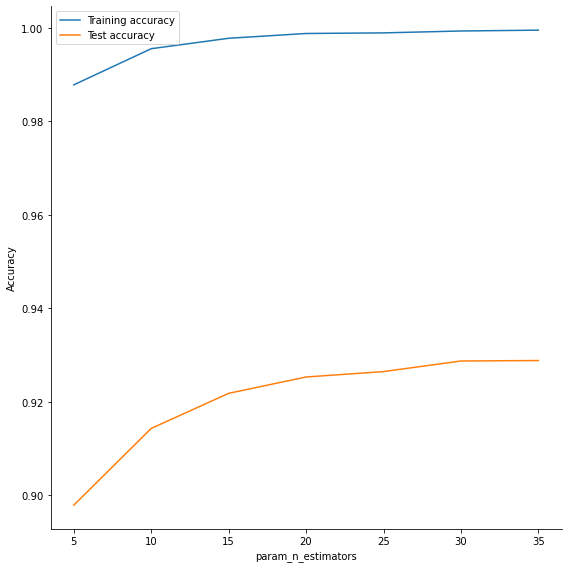

In [189]:
random_forst_feature_graph(grid_search, "n_estimators")

### There seems to be overfitting at n_estimators = 35.

- We will choose 20

### Tuning max_features

In [190]:
parameters = {'max_features': [5, 10, 15, 20, 25, 30]}

rf = RandomForestClassifier(max_depth=25,n_estimators = 20,random_state=10)
grid_search = GridSearchCV(rf, parameters, cv=3, scoring="f1", verbose=1000, return_train_score=True)


grid_search.fit(X_train_rf, y_train_rf)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=5 ..................................................
[CV] .. max_features=5, score=(train=0.999, test=0.924), total=   1.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[CV] max_features=5 ..................................................
[CV] .. max_features=5, score=(train=0.999, test=0.926), total=   1.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[CV] max_features=5 ..................................................
[CV] .. max_features=5, score=(train=0.999, test=0.925), total=   1.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[CV] max_features=10 .................................................
[CV] . max_features=10, score=(train=0.999, test=0.922), total=   3.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=25, n_estimators=20,
                                              random_state=10),
             param_grid={'max_features': [5, 10, 15, 20, 25, 30]},
             return_train_score=True, scoring='f1', verbose=1000)

In [191]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.804658,0.022024,0.041111,0.000873,5,{'max_features': 5},0.923869,0.925912,0.924788,0.924856,0.000835,1,0.998908,0.999142,0.998753,0.998934,0.000160
1,3.387246,0.031780,0.041374,0.001110,10,{'max_features': 10},0.921582,0.923422,0.923124,0.922709,0.000806,2,0.998634,0.998557,0.998324,0.998505,0.000132
2,5.157509,0.093685,0.040512,0.000238,15,{'max_features': 15},0.920620,0.924026,0.922449,0.922365,0.001392,3,0.998635,0.998596,0.998051,0.998427,0.000266
3,6.918408,0.116716,0.040740,0.000058,20,{'max_features': 20},0.918504,0.921759,0.921241,0.920501,0.001428,4,0.997818,0.998986,0.998635,0.998480,0.000489
4,0.018802,0.000953,0.000000,0.000000,25,{'max_features': 25},NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN
5,0.016797,0.003414,0.000000,0.000000,30,{'max_features': 30},NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN


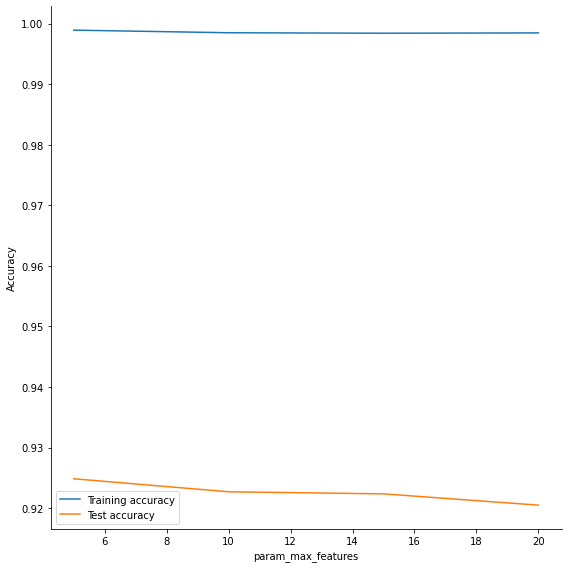

In [192]:
random_forst_feature_graph(grid_search, "max_features")

Selecting max_features = 5

### Tuning min_samples_leaf

In [193]:
parameters = {'min_samples_leaf': range(50, 550, 50)}

rf = RandomForestClassifier(max_depth=25,n_estimators = 20, max_features = 5,random_state=10)
grid_search = GridSearchCV(rf, parameters, cv=3, scoring="f1", verbose=1000, return_train_score=True)


grid_search.fit(X_train_rf, y_train_rf)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] min_samples_leaf=50 .............................................
[CV]  min_samples_leaf=50, score=(train=0.855, test=0.821), total=   1.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[CV] min_samples_leaf=50 .............................................
[CV]  min_samples_leaf=50, score=(train=0.850, test=0.833), total=   1.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[CV] min_samples_leaf=50 .............................................
[CV]  min_samples_leaf=50, score=(train=0.852, test=0.832), total=   1.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s
[CV] min_samples_leaf=100 ............................................
[CV]  min_samples_leaf=100, score=(train=0.823, test=0.798), total=   1.1s
[Parallel(n_jobs=1)]: Done   4 out of

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=25, max_features=5,
                                              n_estimators=20,
                                              random_state=10),
             param_grid={'min_samples_leaf': range(50, 550, 50)},
             return_train_score=True, scoring='f1', verbose=1000)

In [194]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.254860,0.027055,0.029842,0.006060,50,{'min_samples_leaf': 50},0.820725,0.833373,0.832450,0.828849,0.005757,1,0.854557,0.850417,0.852331,0.852435,0.001692
1,1.076387,0.023405,0.029595,0.000959,100,{'min_samples_leaf': 100},0.797781,0.812020,0.811015,0.806939,0.006489,2,0.823082,0.817967,0.822415,0.821155,0.002270
2,1.015548,0.029358,0.027760,0.003730,150,{'min_samples_leaf': 150},0.787388,0.798172,0.792923,0.792828,0.004403,3,0.809913,0.804124,0.804856,0.806298,0.002574
3,0.929109,0.013981,0.023600,0.004726,200,{'min_samples_leaf': 200},0.774907,0.789405,0.788250,0.784188,0.006579,4,0.796477,0.792814,0.794165,0.794485,0.001512
4,0.856812,0.018996,0.022929,0.003764,250,{'min_samples_leaf': 250},0.772324,0.782990,0.778987,0.778100,0.004399,5,0.791183,0.783166,0.782838,0.785729,0.003859
5,0.836224,0.027882,0.021036,0.000868,300,{'min_samples_leaf': 300},0.765272,0.779977,0.781795,0.775681,0.007398,6,0.783490,0.782404,0.782696,0.782863,0.000459
6,0.782542,0.005448,0.026407,0.008672,350,{'min_samples_leaf': 350},0.761048,0.774204,0.776968,0.770740,0.006946,7,0.779757,0.775101,0.776085,0.776981,0.002003
7,0.781225,0.016154,0.020312,0.000083,400,{'min_samples_leaf': 400},0.759987,0.772193,0.771686,0.767955,0.005638,8,0.776418,0.768759,0.767709,0.770962,0.003882
8,0.780372,0.015489,0.020890,0.000852,450,{'min_samples_leaf': 450},0.754219,0.769505,0.769632,0.764452,0.007236,9,0.773086,0.770049,0.769312,0.770816,0.001633
9,0.711958,0.012057,0.020257,0.000075,500,{'min_samples_leaf': 500},0.754504,0.763164,0.764396,0.760688,0.004402,10,0.772389,0.765042,0.765874,0.767768,0.003285


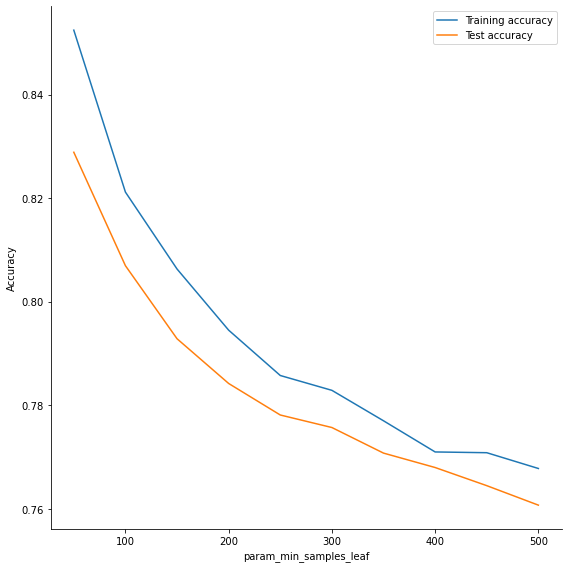

In [195]:
random_forst_feature_graph(grid_search, "min_samples_leaf")

Selecting min_sample_leaf = 50

### Tuning min_samples_split

In [196]:
parameters = {'min_samples_split': range(50, 550, 50)}

rf = RandomForestClassifier(max_depth=25,n_estimators = 20, max_features = 5, min_samples_leaf = 50,random_state=10)
grid_search = GridSearchCV(rf, parameters, cv=3, scoring="f1", verbose=1000, return_train_score=True)


grid_search.fit(X_train_rf, y_train_rf)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] min_samples_split=50 ............................................
[CV]  min_samples_split=50, score=(train=0.855, test=0.821), total=   1.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[CV] min_samples_split=50 ............................................
[CV]  min_samples_split=50, score=(train=0.850, test=0.833), total=   1.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[CV] min_samples_split=50 ............................................
[CV]  min_samples_split=50, score=(train=0.852, test=0.832), total=   1.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s
[CV] min_samples_split=100 ...........................................
[CV]  min_samples_split=100, score=(train=0.855, test=0.821), total=   1.3s
[Parallel(n_jobs=1)]: Done   4 ou

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=25, max_features=5,
                                              min_samples_leaf=50,
                                              n_estimators=20,
                                              random_state=10),
             param_grid={'min_samples_split': range(50, 550, 50)},
             return_train_score=True, scoring='f1', verbose=1000)

In [197]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.244937,0.023914,0.030064,0.000575,50,{'min_samples_split': 50},0.820725,0.833373,0.832450,0.828849,0.005757,1,0.854557,0.850417,0.852331,0.852435,0.001692
1,1.233634,0.008708,0.033749,0.004649,100,{'min_samples_split': 100},0.820725,0.833373,0.832450,0.828849,0.005757,1,0.854557,0.850417,0.852331,0.852435,0.001692
2,1.240670,0.014189,0.029686,0.000804,150,{'min_samples_split': 150},0.812340,0.829056,0.821494,0.820963,0.006834,3,0.843306,0.840651,0.841418,0.841792,0.001115
3,1.174355,0.011391,0.032203,0.002325,200,{'min_samples_split': 200},0.805786,0.821303,0.815329,0.814140,0.006390,4,0.835382,0.834594,0.835496,0.835157,0.000401
4,1.146696,0.003021,0.026967,0.003252,250,{'min_samples_split': 250},0.798936,0.815046,0.814123,0.809368,0.007386,5,0.826546,0.824958,0.827820,0.826441,0.001171
5,1.116916,0.017277,0.030639,0.003246,300,{'min_samples_split': 300},0.797911,0.809974,0.810561,0.806149,0.005830,6,0.823891,0.818142,0.820857,0.820963,0.002348
6,1.127108,0.025737,0.029006,0.001165,350,{'min_samples_split': 350},0.793962,0.807310,0.804235,0.801835,0.005707,7,0.818124,0.813101,0.815377,0.815534,0.002053
7,1.092773,0.012775,0.023508,0.004748,400,{'min_samples_split': 400},0.789969,0.799391,0.799871,0.796410,0.004559,8,0.813862,0.806066,0.810078,0.810002,0.003183
8,1.069099,0.009370,0.026232,0.008585,450,{'min_samples_split': 450},0.787552,0.802818,0.795422,0.795264,0.006233,9,0.810284,0.806005,0.808109,0.808133,0.001747
9,1.031234,0.025473,0.023614,0.003366,500,{'min_samples_split': 500},0.780712,0.800129,0.791852,0.790898,0.007956,10,0.805214,0.802118,0.802171,0.803168,0.001447


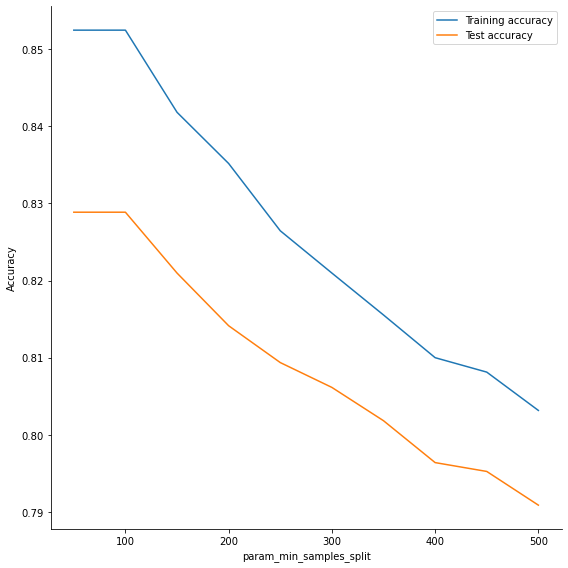

In [198]:
random_forst_feature_graph(grid_search, "min_samples_split")

## Final Random Forest Model

In [199]:
rf_final = RandomForestClassifier(max_depth=25,
                                  n_estimators = 20, 
                                  max_features = 5, 
                                  min_samples_leaf = 50,
                                  min_samples_split=50,
                                  random_state=10)

In [200]:
print("Model performance on Train data:")
modelfit(rf_final,X_train_rf,y_train_rf)

Model performance on Train data:

Model Report
Accuracy : 0.8667
Recall/Sensitivity : 0.8542
AUC Score (Train): 0.945293
CV Score : Mean - 0.918188 | Std - 0.003950756 | Min - 0.9118999 | Max - 0.922452


In [201]:
# predict on test data
predictions = rf_final.predict(X_test_rf)

In [202]:
print("Model performance on Test data:")
getModelMetrics(y_test_rf,predictions)

Model performance on Test data:
Roc_auc_score : 0.7669487427010857
Sensitivity/Recall : 0.6699576868829337
Specificity: 0.8639397985192377
False Positive Rate: 0.13606020148076223
Positive predictive value: 0.2976190476190476
Negative Predictive value: 0.9681719260065288
sklearn precision score value: 0.2976190476190476


Model                            
Train/Test                       
Roc_auc_score                0.77
Sensitivity                  0.67
Specificity                  0.86
FPR                          0.14
Positive predictive value     0.3
Negative Predictive value    0.97
Precision                     0.3
dtype: object

After hyperparameter tuning for the random forest. The Recall rate (Test) is 66.99%.
<br>
Let's see if we can achive a better Recall rate by deciding an optimal cut-off for the model to predict churn.

In [203]:
# predicting churn with default cut-off 0.5
cut_off_prob=0.5
y_train_df,series_metrics = predictChurnWithProb(rf_final,X_train_rf,y_train_rf,cut_off_prob)

Roc_auc_score : 0.8667343010249206
Sensitivity/Recall : 0.8541699183185057
Specificity: 0.8792986837313356
False Positive Rate: 0.12070131626866448
Positive predictive value: 0.8761874266197033
Negative Predictive value: 0.8577446203816484
sklearn precision score value: 0.8761874266197033


     prob  accuracy     sensi     speci
0.0   0.0  0.500338  1.000000  0.000676
0.1   0.1  0.603585  0.999740  0.207429
0.2   0.2  0.729879  0.996462  0.463295
0.3   0.3  0.821003  0.981427  0.660580
0.4   0.4  0.865095  0.935383  0.794808
0.5   0.5  0.866734  0.854170  0.879299
0.6   0.6  0.841501  0.752094  0.930909
0.7   0.7  0.794886  0.627855  0.961917
0.8   0.8  0.729280  0.475261  0.983300
0.9   0.9  0.623537  0.250195  0.996878


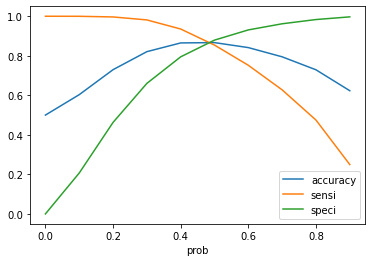

<Figure size 504x360 with 0 Axes>

In [204]:
# finding cut-off with the right balance of the metrices
findOptimalCutoff(y_train_df)

**From the curve above, 0.5 is the optimal point with high enough sensitivity.**

In [205]:
## Training Data 
cut_off_prob=0.50

y_train_df,series_metrics=predictChurnWithProb(rf_final,X_train_rf,y_train_rf,cut_off_prob,model_name='Random Forets',train_or_test='TRAIN')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)
y_train_df.head()

Roc_auc_score : 0.8667343010249206
Sensitivity/Recall : 0.8541699183185057
Specificity: 0.8792986837313356
False Positive Rate: 0.12070131626866448
Positive predictive value: 0.8761874266197033
Negative Predictive value: 0.8577446203816484
sklearn precision score value: 0.8761874266197033


,churn,churn_Prob,final_predicted
0,0,0.325280,0
1,0,0.082432,0
2,1,0.485575,0
3,0,0.389085,0
4,0,0.072042,0


In [206]:
# Testing Data
y_test_df,series_metrics= predictChurnWithProb(rf_final,X_test_rf,y_test_rf,cut_off_prob,model_name='Random Forest',train_or_test='TEST')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.7669487427010857
Sensitivity/Recall : 0.6699576868829337
Specificity: 0.8639397985192377
False Positive Rate: 0.13606020148076223
Positive predictive value: 0.2976190476190476
Negative Predictive value: 0.9681719260065288
sklearn precision score value: 0.2976190476190476


## Random Forest after HyperParameter Tuning
<br>
- <b>Train Sensitivity  :</b> 85.41%, <b>Train Roc-Auc Score  :</b> 86.67%
<br><br>
- <b>Test Sensitivity   :</b> 66.99%, <b>Test ROC-AUC Score  :</b> 76.69%

# 4. Gradient Boosting

In [207]:
# Creating Train-Test variables for Gradient Boosting
X_train_gb = pd.DataFrame(X_train_pca)
y_train_gb = pd.DataFrame(y_train_res)
X_test_gb = pd.DataFrame(X_test_pca)
y_test_gb = y_test

In [208]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm

# Fitting the default GradientBoostingClassifier
gbm = GradientBoostingClassifier(random_state=10)
modelfit(gbm, X_train_gb, y_train_gb)


Model Report
Accuracy : 0.8346
Recall/Sensitivity : 0.835
AUC Score (Train): 0.909006
CV Score : Mean - 0.9000441 | Std - 0.004579276 | Min - 0.8951898 | Max - 0.9065848


### Hyperparameter tuning

In [209]:
param = {'n_estimators':range(10,170,20), 
         'max_depth':range(4,18,2), 
         'min_samples_split':range(250,801,250), }


gbm = GradientBoostingClassifier(random_state=10)
grid_search = GridSearchCV(estimator = gbm, param_grid = param, scoring='f1',n_jobs=-1,verbose=1000, cv=3)


grid_search.fit(X_train_gb, y_train_gb.values.ravel())

Fitting 3 folds for each of 168 candidates, totalling 504 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': range(4, 18, 2),
                         'min_samples_split': range(250, 801, 250),
                         'n_estimators': range(10, 170, 20)},
             scoring='f1', verbose=1000)

In [210]:
grid_search.best_params_

{'max_depth': 16, 'min_samples_split': 250, 'n_estimators': 150}

In [211]:
grid_search.best_score_

0.9296211946533853

In [212]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
151,149.289852,4.191183,0.171054,0.000331,16,250,150,"{'max_depth': 16, 'min_samples_split': 250, 'n...",0.925872,0.932876,0.930116,0.929621,0.002880,1
150,126.460090,4.213225,0.151632,0.000804,16,250,130,"{'max_depth': 16, 'min_samples_split': 250, 'n...",0.923805,0.930711,0.928218,0.927578,0.002855,2
127,137.456899,1.456597,0.155921,0.003725,14,250,150,"{'max_depth': 14, 'min_samples_split': 250, 'n...",0.921549,0.930101,0.924877,0.925509,0.003520,3
149,107.028611,2.853883,0.131178,0.000930,16,250,110,"{'max_depth': 16, 'min_samples_split': 250, 'n...",0.922019,0.927978,0.925571,0.925189,0.002448,4
126,120.881747,3.767597,0.142289,0.006211,14,250,130,"{'max_depth': 14, 'min_samples_split': 250, 'n...",0.919126,0.928506,0.923311,0.923647,0.003837,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,4.534418,0.092982,0.016058,0.004340,6,500,10,"{'max_depth': 6, 'min_samples_split': 500, 'n_...",0.792082,0.807409,0.804817,0.801436,0.006698,164
40,4.926981,0.435508,0.016726,0.004739,6,750,10,"{'max_depth': 6, 'min_samples_split': 750, 'n_...",0.789868,0.803868,0.800780,0.798172,0.006005,165
0,3.332235,0.323882,0.016393,0.005204,4,250,10,"{'max_depth': 4, 'min_samples_split': 250, 'n_...",0.758698,0.778203,0.779934,0.772278,0.009629,166
8,3.455708,0.222570,0.013748,0.005236,4,500,10,"{'max_depth': 4, 'min_samples_split': 500, 'n_...",0.759219,0.776093,0.774388,0.769900,0.007585,167


In [213]:
# GradientBoostingClassifier with tuned Parameters
gbm_final = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150,max_features=20, max_depth=16, 
                                       min_samples_split=250, random_state=10)

modelfit(gbm_final, X_train_gb, y_train_gb)


Model Report
Accuracy : 0.9997
Recall/Sensitivity : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.9796518 | Std - 0.001119844 | Min - 0.9780083 | Max - 0.9808229


In [214]:
# predictions on Test data
dtest_predictions = gbm_final.predict(X_test_gb)

# model Performance on test data
getModelMetrics(y_test_gb,dtest_predictions)

Roc_auc_score : 0.7202706142703242
Sensitivity/Recall : 0.5218617771509168
Specificity: 0.9186794513897317
False Positive Rate: 0.08132054861026823
Positive predictive value: 0.3557692307692308
Negative Predictive value: 0.9571320182094082
sklearn precision score value: 0.3557692307692308


Model                            
Train/Test                       
Roc_auc_score                0.72
Sensitivity                  0.52
Specificity                  0.92
FPR                          0.08
Positive predictive value    0.36
Negative Predictive value    0.96
Precision                    0.36
dtype: object

### Recall value is very low at 0.52

- Let's see if we can achive a better Recall rate by deciding an optimal cut-off for the model to predict churn.

In [215]:
# predicting churn with default cut-off 0.5
cut_off_prob=0.5
y_train_df,series_metrics = predictChurnWithProb(gbm_final,X_train_gb,y_train_gb,cut_off_prob)
y_train_df.head()

Roc_auc_score : 0.99966182820873
Sensitivity/Recall : 1.0
Specificity: 0.99932365641746
False Positive Rate: 0.0006763435825399303
Positive predictive value: 0.9993241135489238
Negative Predictive value: 1.0
sklearn precision score value: 0.9993241135489238


,churn,churn_Prob,final_predicted
0,0,0.008863,0
1,0,0.004422,0
2,1,0.959634,1
3,0,0.063264,0
4,0,0.002892,0


     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.955569  1.000000  0.911139
0.2   0.2  0.988320  1.000000  0.976640
0.3   0.3  0.996904  1.000000  0.993809
0.4   0.4  0.998959  1.000000  0.997919
0.5   0.5  0.999662  1.000000  0.999324
0.6   0.6  0.999922  0.999896  0.999948
0.7   0.7  0.999402  0.998803  1.000000
0.8   0.8  0.995318  0.990635  1.000000
0.9   0.9  0.970579  0.941158  1.000000


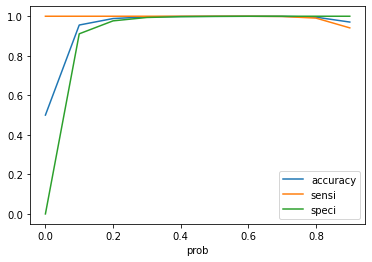

<Figure size 504x360 with 0 Axes>

In [216]:
findOptimalCutoff(y_train_df)

### Observation

- There seems to be overfitting after 0.1

In [217]:
cut_off_prob=0.1
y_train_df,series_metrics = predictChurnWithProb(gbm_final,X_train_gb,y_train_gb,cut_off_prob,model_name='Gradient Boosting',train_or_test='TRAIN')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.9555694292700693
Sensitivity/Recall : 1.0
Specificity: 0.9111388585401384
False Positive Rate: 0.08886114145986161
Positive predictive value: 0.918390749677481
Negative Predictive value: 1.0
sklearn precision score value: 0.918390749677481


In [218]:
y_test_df,series_metrics= predictChurnWithProb(gbm_final,X_test_gb,y_test_gb,cut_off_prob,model_name='Gradient Boosting',train_or_test='TEST')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.7748334275165536
Sensitivity/Recall : 0.7743300423131171
Specificity: 0.7753368127199903
False Positive Rate: 0.2246631872800097
Positive predictive value: 0.22875
Negative Predictive value: 0.9755650580329872
sklearn precision score value: 0.22875


## Gradient Boosting after HyperParameter Tuning
<br>
- <b>Train Sensitivity  :</b> 100%, <b>Train Roc-Auc Score  :</b> 95.55%
<br><br>
- <b>Test Sensitivity   :</b> 77.43%, <b>Test ROC-AUC Score  :</b> 77.48%

### Observation

- There is serious over-fitting even after hyper-parameter tuning and choosing the optimal cutoff point

# 5. XGBoost

In [219]:
# Creating Train-Test variables for XGBoost
X_train_xgb = pd.DataFrame(X_train_pca)
y_train_xgb = pd.DataFrame(y_train_res)
X_test_xgb = pd.DataFrame(X_test_pca)
y_test_xgb = y_test

In [220]:


# Fitting the XGBClassifier without HyperParameter Tuning
xgb = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=-1,
                    seed=27)

In [221]:
# Model fit and performance on Train data
modelfit(xgb, X_train_xgb, y_train_xgb)

[16:32:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:33:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

### Hyperparameter tunning for the XGBClassifer

Tuning max_depth and min_child_weight

In [222]:
param_test1 = {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}

grid_search = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                     min_child_weight=1, gamma=0, subsample=0.8, 
                                                     colsample_bytree=0.8, objective= 'binary:logistic', 
                                                     nthread=-1, scale_pos_weight=1, seed=27), 
                           param_grid = param_test1, scoring='f1',n_jobs=-1, cv=3)

grid_search.fit(X_train_xgb, y_train_xgb)

[16:35:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method

In [223]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.9258662952483158)

### Tuning gamma parameter

In [224]:

param_test2 = {'gamma':[i/10.0 for i in range(0,5)]}
grid_search = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=9,
                                                     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
                                                     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
                           param_grid = param_test2, scoring='f1',n_jobs=-1, cv=3)

grid_search.fit(X_train_xgb, y_train_xgb)

[16:36:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=9, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method

In [225]:
grid_search.best_params_, grid_search.best_score_

({'gamma': 0.4}, 0.9264888866621402)

### Final XGBoost Model


In [226]:
# Final XGBClassifier
xgb = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=9,
                    min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
                    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

In [227]:
# Fit Train data
modelfit(xgb, X_train_xgb, y_train_xgb)

[16:36:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [228]:
# Prediction on Test data
dtest_predictions = xgb.predict(X_test_xgb)

In [229]:
# Model evaluation on Test data
getModelMetrics(y_test_xgb,dtest_predictions)

Roc_auc_score : 0.7353292015973429
Sensitivity/Recall : 0.5585331452750353
Specificity: 0.9121252579196505
False Positive Rate: 0.08787474208034955
Positive predictive value: 0.3535714285714286
Negative Predictive value: 0.9600153295861011
sklearn precision score value: 0.3535714285714286


Model                            
Train/Test                       
Roc_auc_score                0.74
Sensitivity                  0.56
Specificity                  0.91
FPR                          0.09
Positive predictive value    0.35
Negative Predictive value    0.96
Precision                    0.35
dtype: object

### Choosing optimal cut-off value

In [230]:
# predicting churn with default cut-off 0.5
cut_off_prob=0.5
y_train_df,series_metrics = predictChurnWithProb(xgb,X_train_xgb,y_train_xgb,cut_off_prob)
y_train_df.head()

Roc_auc_score : 0.9872014983611674
Sensitivity/Recall : 0.9949014099162374
Specificity: 0.9795015868060974
False Positive Rate: 0.020498413193902502
Positive predictive value: 0.9798124711789722
Negative Predictive value: 0.9948216644649934
sklearn precision score value: 0.9798124711789722


,churn,churn_Prob,final_predicted
0,0,0.002771,0
1,0,0.030964,0
2,1,0.910517,1
3,0,0.221486,0
4,0,0.012126,0


     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.893320  1.000000  0.786640
0.2   0.2  0.946959  0.999948  0.893970
0.3   0.3  0.969643  0.999584  0.939701
0.4   0.4  0.981661  0.998491  0.964830
0.5   0.5  0.987201  0.994901  0.979502
0.6   0.6  0.987930  0.987514  0.988346
0.7   0.7  0.982779  0.971333  0.994225
0.8   0.8  0.961683  0.925810  0.997555
0.9   0.9  0.896181  0.792623  0.999740


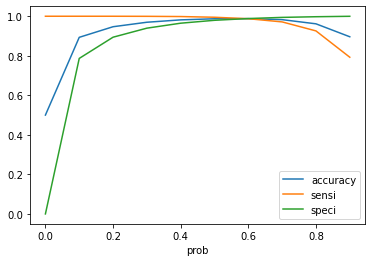

<Figure size 504x360 with 0 Axes>

In [231]:
# Finding optimal cut-off probability
findOptimalCutoff(y_train_df)

In [232]:
# Selecting 0.3 as cut-off
cut_off_prob=0.3
y_train_df,series_metrics = predictChurnWithProb(xgb,X_train_xgb,y_train_xgb,cut_off_prob,model_name='XGBoost',train_or_test='TRAIN')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.9696425784298424
Sensitivity/Recall : 0.9995837885645908
Specificity: 0.9397013682950939
False Positive Rate: 0.06029863170490609
Positive predictive value: 0.9431081877086197
Negative Predictive value: 0.999557277255119
sklearn precision score value: 0.9431081877086197


In [233]:
y_test_df,series_metrics= predictChurnWithProb(xgb,X_test_xgb,y_test_xgb,cut_off_prob,model_name='XGBoost',train_or_test='TEST')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.7716487735667046
Sensitivity/Recall : 0.68688293370945
Specificity: 0.8564146134239592
False Positive Rate: 0.14358538657604078
Positive predictive value: 0.29161676646706586
Negative Predictive value: 0.9694971145919209
sklearn precision score value: 0.29161676646706586


## XGBoost after HyperParameter Tuning
<br>
- <b>Train Sensitivity  :</b> 99.94%, <b>Train Roc-Auc Score  :</b> 96.95%
<br><br>
- <b>Test Sensitivity   :</b> 67.84%, <b>Test ROC-AUC Score  :</b> 76.56%

# 6. Support Vector Machine

In [234]:
# Creating Train-Test variables for SVM
X_train_svm = pd.DataFrame(X_train_pca)
y_train_svm = pd.DataFrame(y_train_res)
X_test_svm = pd.DataFrame(X_test_pca)
y_test_svm = y_test

In [235]:
# instantiate an object of class SVC()
# note that we are using cost C=1
svm0 = SVC(C = 1)

In [236]:
# fit
svm0.fit(X_train_svm, y_train_svm)

# predict on train
y_pred = svm0.predict(X_train_svm)

series_metrics=getModelMetrics(y_train_svm,y_pred,model_name='SVM',train_or_test='TRAIN')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.8447011081629467
Sensitivity/Recall : 0.8427761302741793
Specificity: 0.8466260860517143
False Positive Rate: 0.15337391394828573
Positive predictive value: 0.846033321146916
Negative Predictive value: 0.8433791137600415
sklearn precision score value: 0.846033321146916


In [237]:
# Predict on test
y_pred = svm0.predict(X_test_svm)
getModelMetrics(y_test_svm,y_pred)

Roc_auc_score : 0.7843175437061785
Sensitivity/Recall : 0.7249647390691114
Specificity: 0.8436703483432455
False Positive Rate: 0.15632965165675447
Positive predictive value: 0.28523862375138737
Negative Predictive value: 0.9727120067170445
sklearn precision score value: 0.28523862375138737


Model                            
Train/Test                       
Roc_auc_score                0.78
Sensitivity                  0.72
Specificity                  0.84
FPR                          0.16
Positive predictive value    0.29
Negative Predictive value    0.97
Precision                    0.29
dtype: object

## Hyper Parameter Tuning

### Linear Kernal

In [238]:
# specify range of parameters (C) as a list
params = {"C": [0.1, 1, 10, 100, 1000]}

svm1 = SVC()

# set up grid search scheme
# note that we are still using the 5 fold CV scheme
model_cv = GridSearchCV(estimator = svm1, param_grid = params, 
                        scoring= 'f1', cv = 5, verbose = 1, n_jobs=-1,
                       return_train_score=True) 

model_cv.fit(X_train_svm, y_train_svm.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.8min finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000]}, return_train_score=True,
             scoring='f1', verbose=1)

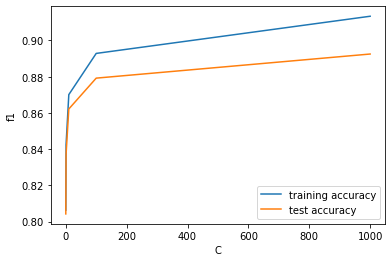

In [239]:
plot_traintestAcc(model_cv.cv_results_,'C')

In [240]:
model_cv.best_params_

{'C': 1000}

In [241]:
svm_final = SVC(C = 1000)
# fit
svm_final.fit(X_train_svm, y_train_svm.values.ravel())

SVC(C=1000)

In [242]:
# predict
y_pred = svm_final.predict(X_test_svm)

In [243]:
series_metric=getModelMetrics(y_test_svm,y_pred)

Roc_auc_score : 0.7513607492385026
Sensitivity/Recall : 0.6248236953455572
Specificity: 0.8778978031314479
False Positive Rate: 0.122102196868552
Positive predictive value: 0.305728088336784
Negative Predictive value: 0.9645286038138419
sklearn precision score value: 0.305728088336784


#### Using non-linear kernal

In [244]:
svm_k = SVC(C = 1000, kernel='rbf')
svm_k.fit(X_train_svm, y_train_svm)

SVC(C=1000)

In [245]:
y_pred = svm_k.predict(X_test_svm)

In [246]:
series_metrics=getModelMetrics(y_test_svm,y_pred,model_name='SVM',train_or_test='TEST')
metricsdataframe=WriteModelMetrics(series_metrics,metricsdataframe)

Roc_auc_score : 0.7513607492385026
Sensitivity/Recall : 0.6248236953455572
Specificity: 0.8778978031314479
False Positive Rate: 0.122102196868552
Positive predictive value: 0.305728088336784
Negative Predictive value: 0.9645286038138419
sklearn precision score value: 0.305728088336784


## SVM after HyperParameter Tuning
<br>
- <b>Train Sensitivity  :</b> 84.27%, <b>Train Roc-Auc Score  :</b> 84.46%
<br><br>
- <b>Test Sensitivity   :</b> 62.48%, <b>Test ROC-AUC Score  :</b> 75.14%

In [247]:
all_model_data = metricsdataframe#pd.read_csv("all_data.csv")

In [248]:
all_model_data

,Model,Train/Test,Roc_auc_score,Sensitivity,Specificity,FPR,Positive predictive value,Negative Predictive value,Precision
0,Logistic Regression,TRAIN,0.79,0.84,0.73,0.27,0.76,0.82,0.76
1,Logistic Regression,TEST,0.76,0.79,0.74,0.26,0.21,0.98,0.21
2,Decision Tree,TRAIN,0.82,0.83,0.80,0.20,0.81,0.83,0.81
3,Decision Tree,TEST,0.72,0.65,0.78,0.22,0.20,0.96,0.20
4,Random Forets,TRAIN,0.87,0.85,0.88,0.12,0.88,0.86,0.88
5,Random Forest,TEST,0.77,0.67,0.86,0.14,0.30,0.97,0.30
6,Gradient Boosting,TRAIN,0.96,1.00,0.91,0.09,0.92,1.00,0.92
7,Gradient Boosting,TEST,0.77,0.77,0.78,0.22,0.23,0.98,0.23
8,XGBoost,TRAIN,0.97,1.00,0.94,0.06,0.94,1.00,0.94
9,XGBoost,TEST,0.77,0.69,0.86,0.14,0.29,0.97,0.29


In [249]:
# Getting the evaluation score for the test data.
test_scores = all_model_data.loc[all_model_data["Train/Test"]=="TEST"]

## Looking at Sensitivity scores

Sensitivity (True Positive rate) measures the proportion of positives (churn in this case) that are correctly identified (i.e. the proportion of those who have some condition (affected) who are correctly identified as having the condition).


We don't want to lose out on potential churn customers and spending few extra advertising money on non-churn customers is taken to be acceptable. So, Sensitivity is most appropriate evaluation metric in this case.

In [250]:
# Checking for evaluation metric on test data for different models.
test_scores.head()

,Model,Train/Test,Roc_auc_score,Sensitivity,Specificity,FPR,Positive predictive value,Negative Predictive value,Precision
1,Logistic Regression,TEST,0.76,0.79,0.74,0.26,0.21,0.98,0.21
3,Decision Tree,TEST,0.72,0.65,0.78,0.22,0.20,0.96,0.20
5,Random Forest,TEST,0.77,0.67,0.86,0.14,0.30,0.97,0.30
7,Gradient Boosting,TEST,0.77,0.77,0.78,0.22,0.23,0.98,0.23
9,XGBoost,TEST,0.77,0.69,0.86,0.14,0.29,0.97,0.29


In [251]:
# Creating dataframe with only sesitivity score on the test data for different models.
sen_score = test_scores[["Model", "Sensitivity"]]

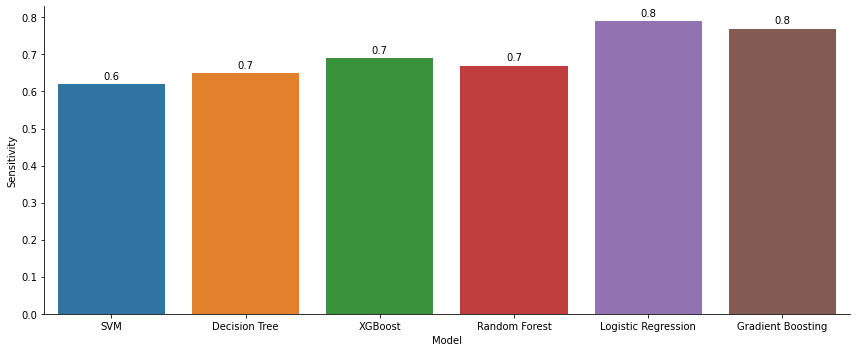

In [252]:
# Plotting the bar plot for sensitivity on test data for different models. 
plt.figure(figsize=(12,5))

myOrder = ["SVM", "Decision Tree", "XGBoost", "Random Forest", "Logistic Regression", "Gradient Boosting"]

ax = sns.barplot(sen_score.Model, sen_score.Sensitivity, order=myOrder)

annotate_graph(ax)
sns.despine()
plt.tight_layout()
plt.show()

## Identifying relevant churn features. 

We will use an instance of Random Forest classifier to identify the features most relevant to churn. 

In [253]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,20,30],
    'min_samples_leaf': range(50, 401, 100),
    'min_samples_split': range(50, 401, 100),
    'n_estimators': [50, 100, 200, 300], 
    'max_features': [10, 15, 20, 25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 10000 )

In [254]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [10, 15, 20, 25],
                         'min_samples_leaf': range(50, 401, 100),
                         'min_samples_split': range(50, 401, 100),
                         'n_estimators': [50, 100, 200, 300]},
             verbose=10000)

In [255]:
# printing the optimal accuracy score and hyperparameters
grid_search.best_score_,grid_search.best_params_

(0.9455355016529218,
 {'max_depth': 10,
  'max_features': 20,
  'min_samples_leaf': 50,
  'min_samples_split': 150,
  'n_estimators': 50})

In [256]:
rf = RandomForestClassifier(max_depth=10,
                            max_features=20,
                            min_samples_leaf=50,
                            min_samples_split=150,
                            n_estimators=50,
                            random_state=10)

In [257]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=20, min_samples_leaf=50,
                       min_samples_split=150, n_estimators=50, random_state=10)

In [258]:
plt.figure(figsize=(15,40))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

feat_importances.nlargest(len(X_train.columns)).sort_values(ascending=False).head(10)

total_ic_mou_8           0.286984
total_og_mou_8           0.164954
arpu_8                   0.098440
total_rech_amt_8         0.095568
last_day_rch_amt_8       0.039716
total_data_rech_amt_8    0.035746
max_rech_amt_8           0.033852
fb_user_8                0.032852
av_rech_amt_data_8       0.022016
max_rech_data_8          0.019848
dtype: float64

<Figure size 1080x2880 with 0 Axes>

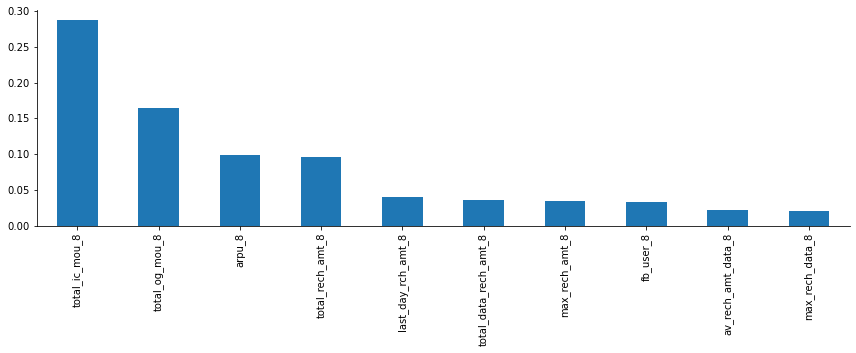

In [259]:
plt.figure(figsize=(12,5))


ax = feat_importances.nlargest(len(X.columns)).sort_values(ascending=False).head(10).plot(kind='bar', align='center')

# annotate_graph(ax)
sns.despine()
plt.tight_layout()



plt.show()


In [260]:
top_ten_col_df = feat_importances.nlargest(len(X_train.columns)).sort_values(ascending=False).head(10)

In [261]:
top_ten_col_df

total_ic_mou_8           0.286984
total_og_mou_8           0.164954
arpu_8                   0.098440
total_rech_amt_8         0.095568
last_day_rch_amt_8       0.039716
total_data_rech_amt_8    0.035746
max_rech_amt_8           0.033852
fb_user_8                0.032852
av_rech_amt_data_8       0.022016
max_rech_data_8          0.019848
dtype: float64

## Creating Logistic Regression for these important features

In [262]:
lg = LogisticRegression()

In [263]:
top_ten_cols = top_ten_col_df.index

In [264]:
X_train[top_ten_cols]

,total_ic_mou_8,total_og_mou_8,arpu_8,total_rech_amt_8,last_day_rch_amt_8,total_data_rech_amt_8,max_rech_amt_8,fb_user_8,av_rech_amt_data_8,max_rech_data_8
28686,-0.491847,-0.468816,-0.649108,-0.655106,-0.192308,8.902077,-0.709459,1.0,1.275510,0.012987
10022,0.062416,-0.140297,-0.447252,-0.443160,0.615385,-0.074184,0.000000,0.0,-0.127551,-0.149351
17476,0.085896,1.722481,0.799874,1.042389,0.615385,-0.074184,0.263514,0.0,-0.127551,-0.149351
7874,-0.113682,-0.298456,-0.597114,-0.489403,0.276923,1.753709,-0.202703,1.0,1.443878,0.850649
25139,0.415151,-0.172723,0.019659,0.015414,-0.153846,2.133531,0.459459,1.0,1.137755,1.136364
...,...,...,...,...,...,...,...,...,...,...
21170,-0.122663,-0.035101,0.721501,0.019268,3.461538,-0.074184,2.500000,0.0,-0.127551,-0.149351
8906,1.190151,-0.201551,0.013232,0.025048,-0.100000,0.091988,-0.466216,1.0,0.158163,0.214286
21400,0.469376,0.180715,0.443517,0.308285,0.615385,-0.074184,0.000000,0.0,-0.127551,-0.149351
17444,2.751419,1.132248,1.911801,1.832370,-0.130769,6.454006,-0.540541,1.0,0.892857,0.012987


In [265]:
modelfit(lg, X_train[top_ten_cols], y_train)


Model Report
Accuracy : 0.5029
Recall/Sensitivity : 0.006042
AUC Score (Train): 0.871023
CV Score : Mean - 0.8700943 | Std - 0.009413826 | Min - 0.854634 | Max - 0.8805338


In [266]:
# predictions on Test data
pred_probs_test = lg.predict(X_test[top_ten_cols])
getModelMetrics(y_test,pred_probs_test)

Roc_auc_score : 0.5007052186177715
Sensitivity/Recall : 0.0014104372355430183
Specificity: 1.0
False Positive Rate: 0.0
Positive predictive value: 1.0
Negative Predictive value: 0.9208673298312283
sklearn precision score value: 1.0


Model                            
Train/Test                       
Roc_auc_score                 0.5
Sensitivity                     0
Specificity                     1
FPR                             0
Positive predictive value       1
Negative Predictive value    0.92
Precision                       1
dtype: object

In [267]:
print("Accuracy : {}".format(metrics.accuracy_score(y_test,pred_probs_test)))
print("Recall : {}".format(metrics.recall_score(y_test,pred_probs_test)))
print("Precision : {}".format(metrics.precision_score(y_test,pred_probs_test)))

Accuracy : 0.9208761734465802
Recall : 0.0014104372355430183
Precision : 1.0


In [268]:
cut_off_prob=0.5
y_train_df,series_metrics = predictChurnWithProb(lg,X_train[top_ten_cols],y_train,cut_off_prob)


Roc_auc_score : 0.5029170951774015
Sensitivity/Recall : 0.006042296072507553
Specificity: 0.9997918942822954
False Positive Rate: 0.00020810571770459393
Positive predictive value: 0.7142857142857143
Negative Predictive value: 0.9211484996644617
sklearn precision score value: 0.7142857142857143


# Logistic Regression
### Hyper Parameter Tuning


**Finding Optimal Cutoff Point**
\
\
Since recall or sensitivity is a much more important metrics for churn prediction. A trade off between sensitivity(or recall) and specificity is to be considered in doing so. We will try adjusting the probability threshold which shall lead to higher sensitivity or recall rate.

     prob  accuracy     sensi     speci
0.0   0.0  0.079278  1.000000  0.000000
0.1   0.1  0.820176  0.778852  0.823734
0.2   0.2  0.896101  0.679758  0.914729
0.3   0.3  0.923501  0.606042  0.950835
0.4   0.4  0.940123  0.516616  0.976588
0.5   0.5  0.921010  0.006042  0.999792
0.6   0.6  0.920722  0.000604  0.999948
0.7   0.7  0.920674  0.000000  0.999948
0.8   0.8  0.920722  0.000000  1.000000
0.9   0.9  0.920722  0.000000  1.000000


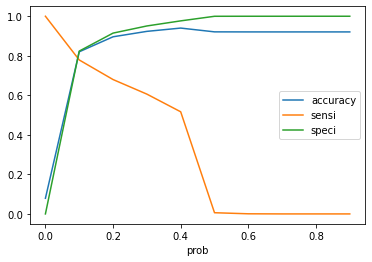

<Figure size 504x360 with 0 Axes>

In [269]:
# finding cut-off with the right balance of the metrices
# sensitivity vs specificity trade-off
findOptimalCutoff(y_train_df)

#### **From the curve above, 0.1 is the optimum point .**


In [270]:
# predicting with the choosen cut-off on TRAIN
cut_off_prob=0.1
y_train_df,series_metrics = predictChurnWithProb(lg, X_train[top_ten_cols],y_train,cut_off_prob)


Roc_auc_score : 0.8012932104252163
Sensitivity/Recall : 0.7788519637462236
Specificity: 0.8237344571042089
False Positive Rate: 0.17626554289579105
Positive predictive value: 0.2756040196707291
Negative Predictive value: 0.9774060127168344
sklearn precision score value: 0.2756040196707291


In [271]:
# predicting with the choosen cut-off on TEST
cut_off_prob=0.1
y_train_df,series_metrics = predictChurnWithProb(lg, X_test[top_ten_cols],y_test,cut_off_prob)


Roc_auc_score : 0.7946425468603606
Sensitivity/Recall : 0.7616361071932299
Specificity: 0.8276489865274912
False Positive Rate: 0.1723510134725088
Positive predictive value: 0.2755102040816326
Negative Predictive value: 0.9758156840297653
sklearn precision score value: 0.2755102040816326


In [272]:
lg.intercept_

array([-1.9723338])

In [273]:
list(X_train[top_ten_cols].columns)

['total_ic_mou_8',
 'total_og_mou_8',
 'arpu_8',
 'total_rech_amt_8',
 'last_day_rch_amt_8',
 'total_data_rech_amt_8',
 'max_rech_amt_8',
 'fb_user_8',
 'av_rech_amt_data_8',
 'max_rech_data_8']

In [274]:
list(lg.coef_)

[array([-1.99197324e+00, -9.40287751e-01,  1.10438696e-01, -1.65490021e-01,
        -4.70701264e-01, -1.68789730e-01,  1.44572251e-01, -1.83904983e+00,
        -8.76808745e-04,  7.20159088e-02])]

In [275]:
print(type(lg.coef_))

<class 'numpy.ndarray'>


In [276]:
lg.coef_.tolist()[0]

[-1.9919732444513725,
 -0.9402877513017519,
 0.1104386961392474,
 -0.1654900211195374,
 -0.47070126437007925,
 -0.16878972972449763,
 0.14457225083319103,
 -1.839049828877819,
 -0.0008768087446611616,
 0.07201590881427021]

In [277]:
log_coef_top_ten = pd.DataFrame({"col":list(X_train[top_ten_cols].columns), "value":lg.coef_.tolist()[0]})

In [278]:
log_coef_top_ten.sort_values(by="value")

,col,value
0,total_ic_mou_8,-1.991973
7,fb_user_8,-1.839050
1,total_og_mou_8,-0.940288
4,last_day_rch_amt_8,-0.470701
5,total_data_rech_amt_8,-0.168790
3,total_rech_amt_8,-0.165490
8,av_rech_amt_data_8,-0.000877
9,max_rech_data_8,0.072016
2,arpu_8,0.110439
6,max_rech_amt_8,0.144572


# Interpretation/Business Recommendations

1. There are about 8 % of the customers who will churn based on the given data. Which is good showing that majority of customers are happy with the service.

2. The customers who are more likely to churn have recharged very few times and with less amount in good and action phase. Giving some better offers to such customer will definitely boost the telecom business and stop to some extend customers from churning.

3. Large number of Customers are new to Telecom Company.

4. The service schemes for Facebook seems to be popular among the potential churn customers. The company can offer better Facebook schemes to retain such customers.

5. The average revenue of the potential churn customer almost same with non-churn customer but reduces drastically in the action (August) month. This can be considered as churn indication.

6. The outgoing calls, incoming calls, inter net recharge, total amount of talk time recharge reduces drastically in the action (August) month. The company must consider such behaviour as churn indication for such customers and should take appropriate action.

7. It is also seen that the customers who recharge with less amount are more likely to churn. It is recommended that the company can offer some cost effective packages for such customers to stop them from churning. 

8. Customer behaviour in 8 th month or the action phase can considered as base indicator of churn analysis.

9. Lower the value of Incoming calls(total_ic_mou_8), facebook service schemes (fb_user_8),out going calls(total_og_mou_8) more likely is the customer to churn. Hence, these are top 3 important predictors of churn. 